In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

## !/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Dec 11 15:42:20 2020

@author: eceakcicek
"""

import math
from sklearn.metrics import accuracy_score
import time
import os, psutil
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
import random
from sklearn.model_selection import train_test_split

################# MAIN GA FUNCTIONS
def init_population(n,c):
    return np.array([[math.ceil(e) for e in pop] for pop in (np.random.rand(n,c)-0.5)]), np.zeros((2,c))-1

def single_point_crossover(population):
    r,c = population.shape[0], population.shape[1]
    n = np.random.randint(1,c)     
    
    for i in range(0,r,2):                
        population[i], population[i+1] = np.append(population[i][0:n],population[i+1][n:c]),np.append(population[i+1][0:n],population[i][n:c])        
    return population

# does cross-over on 2 agents chosen by tournament
# replaces offsprings with least fit %50
def double_point_crossover(population, fitness):
    r,c = population.shape[0], population.shape[1]
    n1 = np.random.randint(1,c-1)  
    n2 = np.random.randint(n1,c)  
    # for i in range(0,r,2):
    for i in range(round(r/2)):
        g1 = tournament_selection(population, fitness)
        g2 = tournament_selection(population, fitness)
        #population[g1] = np.append(np.append(population[g1][0:n1],population[g2][n1:n2]), population[g1][n2:c])
        #population[g2] = np.append(np.append(population[g2][0:n1],population[g1][n1:n2]), population[g2][n2:c])        
        population[r-(i+1)] = np.append(np.append(population[g1][0:n1],population[g2][n1:n2]), population[g1][n2:c])
    return population

# cross over between elements which has lowest and highest accuracy and replace the lowest one
# takes sorted population
def minmax_double_point_crossover(population):
    r,c = population.shape[0]-1, population.shape[1]
    #for i in range(round(r/10)): 
    for i in range(1): 
        n1 = np.random.randint(1,c-1)  
        n2 = np.random.randint(n1,c) 
        population[r-i] = np.append(np.append(population[r-i][0:n1],population[i][n1:n2]), population[r-i][n2:c]) 
    return population

def flip_mutation(population):
    return population.max() - population

# selects a random gene of a random element
# mutates it
def random_gene_mutation(population):
    r,c = population.shape[0], population.shape[1]
    element = np.random.randint(1,r)
    gene = np.random.randint(1,c)
    if population[element][gene] == 0:
        population[element][gene] = 1
    if population[element][gene] == 1:
        population[element][gene] = 0
    return population

# randomly selects an agent
# randomly selects a subset of genes
# shuffles values
def scrambled_mutation(population):
    r,c = population.shape[0], population.shape[1]
    #for i in range(round(r/5)):
    for i in range(r):
        element = np.random.randint(3,r)
        p1 = np.random.randint(1,(c-10))
        p2 = p1+10
        np.random.shuffle(population[element][p1:p2])
    return population

# selection by tournament to select parents for crossover
# returns the population[] index of champion
def tournament_selection(population, fitness):
    k = 5
    cand_fitness = []
    cand_fit_index = []
    candidates = random.choices(population, k=k)
    candidates = np.array(candidates)
    for i in range(k):
        for j in range(population.shape[0]):
            if (candidates[i] == population[j]).all():
                cand_fitness.append(fitness[j])
                cand_fit_index.append(j)
    champ = cand_fit_index[cand_fitness.index(max(cand_fitness))]
    return champ

def random_selection(population):
    r = population.shape[0]
    new_population = population.copy()    
    for i in range(r):        
        new_population[i] = population[np.random.randint(0,r)]
    return new_population
    
########################## GA ADDITIVE
    
def memorize(pop, memory):      
    return np.append(memory, pop.reshape(1,memory.shape[1]), axis=0)

def replace_duplicate(population, memory):    
    for i in range(population.shape[0]):         
        counter = 0                
        while population.shape[1] in sum((memory==population[i]).astype(int).T) and counter<100:                                
            population[i] = np.array([math.ceil(k) for k in (np.random.rand(population.shape[1])-0.5)])                    
            counter += 1                    
        memory = memorize(population[i], memory)        
    return population, memory

def sort_fitness_pop(fitness, population, accuracy):
    r = population.shape[0]
    population_sorted = population.copy()    
    fitness_sorted = fitness.copy()
    accuracy_sorted = accuracy.copy()
    # to keep most accurate and most fit solutions through iterations, put most accurate as 1st element
    # and sort rest as their fitness
    most_acc_index = accuracy.index(max(accuracy))
    population_sorted[0] = population[most_acc_index]
    fitness_sorted[0] = fitness.pop(most_acc_index)
    accuracy_sorted[0] = accuracy.pop(most_acc_index)
    for i in range(r-1):        
        max_index = fitness.index(max(fitness))
        population_sorted[i+1] = population[max_index]
        fitness_sorted[i+1] = fitness.pop(max_index)
        accuracy_sorted[i+1] = accuracy.pop(max_index)
    return fitness_sorted, population_sorted, accuracy_sorted

def fitness_population_average(fitness):
    m = 0
    for i in range(len(fitness)):
        m = m+fitness[i]
    return m/len(fitness)

######################### GA INTERFACE
def get_fitness(data, feature_list, target, population, accuracy):
    fitness = []
    for i in range(population.shape[0]):
        solution = population[i] 
        feat_set = [solution[i] for i in range(len(solution)) if solution[i]==1]
        numofselected = len(feat_set)
        fitness.append(pow(accuracy[i],2)/math.sqrt(numofselected))
    return fitness
    
def get_accuracy(data, feature_list, target, population):    
    accuracy = []
    for i in range(population.shape[0]):        
        columns = [feature_list[j] for j in range(population.shape[1]) if population[i,j]==1]                    
        accuracy.append(predictive_model(data[columns], data[target]))                
    return accuracy

def predictive_model(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)
    lr = LogisticRegression(solver='liblinear', max_iter=10000, random_state=7)
    lr.fit(X_train,y_train)    
    return accuracy_score(y_test, lr.predict(X_test))

######################## NARROW DOWN BY RELEVANCE

def narrowdown_byrelevance(data, feature_list, solution, target, featavg):

    feature_indexes = [i for i in range(len(feature_list)) if solution[i]==1]
    feature_set = [feature_list[i] for i in range(len(feature_list)) if solution[i]==1]
    
    solution_feat_importance = feat_relevance(data, feature_set, target)
    
    new_sol = solution
    
    lower_values = []
    lower_indexes = []
    for i,v in enumerate(solution_feat_importance):
        if abs(v)<featavg:
            lower_indexes.append(feature_indexes[i])
            lower_values.append(featavg-abs(v))
    
    lower_index_sorted =[]
    for i in range(len(lower_values)):
        ind = lower_values.index(max(lower_values))
        lower_values.pop(ind)
        lower_index_sorted.append(lower_indexes[ind])
          
    for i in range(len(lower_index_sorted)):
        if (i%5)!=0:
            new_sol[(lower_index_sorted[i])] = 0
        
    #for i,v in enumerate(solution_feat_importance):
    #    if abs(v)<featavg:
    #       new_sol[(feature_indexes[i])] = 0
                         
    return new_sol
        
def narrowdown_byrelevancePOP(data, population, feature_list, target):
    
    importance = feat_relevance(data, feature_list, target)
    
    sumrel=0
    for i,v in enumerate(importance):
        sumrel = sumrel + abs(v) ##ABS V mi?
    
    featavg = abs(sumrel / len(importance))
    
    for i in range(population.shape[0]):
        sol = narrowdown_byrelevance(data, feature_list, population[i], target, featavg)
        population[i] = sol
    
    return population

######################## OUTPUT RELEVANCE

def feat_relevance(data, solution, target):
    X_train, X_test, y_train, y_test = train_test_split(data[solution], data[target], test_size=0.3)
    model = LogisticRegression(solver='liblinear', max_iter=10000, random_state=7)
    model.fit(X_train,y_train)
    importance = model.coef_[0]
    return importance  

######################## MAIN CODE
def ga(data, feature_list, target, n, max_iter):
    
    start_time = time.time()
    
    c = len(feature_list) 
    
    opt_vals = []
    opt_fit_vals = []
    numof_feat = []
    avg_fitness = []
    
    population, memory = init_population(n,c)
    population, memory = replace_duplicate(population, memory)  
    
    accuracy    = get_accuracy(data, feature_list, target, population)
    fitness    = get_fitness(data, feature_list, target, population, accuracy)
    
    fitness, population, accuracy = sort_fitness_pop(fitness, population, accuracy)
    
    optimal_value    = max(fitness)
    optimal_solution = population[np.where(fitness==optimal_value)][0]
    optimal_accuracy = accuracy[fitness.index(optimal_value)]
    
    numofiter=0
    
    for i in range(max_iter):

        minmax_double_point_crossover(population)
 #       population = random_selection(population)
        population = double_point_crossover(population,  fitness)                        
        
        if np.random.rand() < 0.2:
 #           population = flip_mutation(population)
 #           population = random_gene_mutation(population)
            population = scrambled_mutation(population)
        
        population = narrowdown_byrelevancePOP(data, population, feature_list, target)
    
        population, memory = replace_duplicate(population, memory)
                
        accuracy = get_accuracy(data, feature_list, target, population)
        fitness = get_fitness(data, feature_list, target, population, accuracy)
        
        fitness, population, accuracy = sort_fitness_pop(fitness, population, accuracy)
            
        if max(fitness) > optimal_value:
            optimal_value    = max(fitness)
            optimal_solution = population[np.where(fitness==optimal_value)][0] 
            optimal_accuracy = accuracy[fitness.index(optimal_value)]
            
        
        numofiter=numofiter+1
        #print('Number of iteration: ',numofiter)  
        
        feat_set = optimal_solution        
        
        # to plot avg fitness of population
        avg_fitness.append(fitness_population_average(fitness)*1000)
        
        # to plot optimal fitness values
        opt_fit_vals.append(optimal_value*1000)
        
        # to plot optimal accuracy values
        opt_vals.append(optimal_accuracy * 100)
        
        # to print num of selected features of most fit
        feat_set = [optimal_solution[i] for i in range(len(optimal_solution)) if optimal_solution[i]==1]
        numof_feat.append(len(feat_set))
        
        #print('Optimal Feature Set\n',feat_set, '\nOptimal Accuracy =', optimal_value*100, '%' , ' \n')
    
    end_time = time.time()    
    return optimal_solution, optimal_accuracy, end_time-start_time, opt_vals, numof_feat, opt_fit_vals, avg_fitness

In [3]:
def ga_trial(df1, feature_list, target, n, iteration):
    feature_set, acc_score, exec_time, opt_vals, numof_feat, opt_fit_vals, avg_fitness = ga(df1, feature_list, target, n, iteration)

    # Filter Selected Features
    feature_indexes = [i for i in range(len(feature_list)) if feature_set[i]==1]
    feature_set = [feature_list[i] for i in range(len(feature_list)) if feature_set[i]==1]
    
    # Print List of Features
    print('FINAL Optimal Feature Set\n',feature_indexes)
    print('FINAL Optimal Accuracy =', acc_score*100, '%')
    print('Execution time is: ', exec_time)
    print('Number of selected features is: ', len(feature_set))

    #print outcomes through iterations
    plt.subplots(figsize=(18,5))
    plt.title('GA outcomes through iterations')
    plt.plot(opt_vals, label="optimal accuracy")
    plt.plot(numof_feat, label="# of features")
    plt.plot(opt_fit_vals, label="optimal fitness")
    plt.plot(avg_fitness, label="average population fitness")
    print('Number of features selected through iterations: ')
    plt.legend()
    plt.show()

    print('Final solution feature relevance: ')
    importance = feat_relevance(df1, feature_set, target)
    for i,v in enumerate(importance):
        #print('Feature:', i, ' Score: %.5f' % v)
        print('Feature:', feature_indexes[i], ' Score: %.5f' % v)
        # plot feature importance
    plt.subplots(figsize=(18,5))
    plt.bar([feature_indexes[x] for x in range(len(feature_indexes))], importance)
    plt.show()  
    
    return acc_score*100, exec_time, len(feature_set)

In [4]:
def ga_multiple_trials(howmany, df1, feature_list, target, n, iteration):
    
    accuracies = []
    avg_exectime = 0
    numfeatures = []
    
    for i in range(howmany):
        print("Trial ", i+1)
        acc, exc, fea = ga_trial(df1, feature_list, target, n, iteration)
        accuracies.append(acc)
        avg_exectime = avg_exectime + exc
        numfeatures.append(fea)
        
    avg_acc=0
    avg_feat=0
    
    for i in range(len(accuracies)):
        avg_acc = avg_acc + accuracies[i]
        avg_feat = avg_feat + numfeatures[i]
    
    avg_acc = avg_acc/len(accuracies)
    avg_feat = avg_feat/len(numfeatures)
    
    print("--------------------------------------------------")
    print("Average accuracy: ", avg_acc)
    print("Average execution time: ", avg_exectime)
    print("Average number of features selected: ", avg_feat)
    
    plt.subplots(figsize=(10,5))
    plt.title('Outputs through iterations')
    plt.plot(accuracies, label="accuracies")
    plt.plot(numfeatures, label="# of features")
    plt.legend()
    plt.show()

In [6]:
df1 = pd.read_csv("data2.csv")

col= []
for i in range(df1.shape[1]-1):
    col.append(i)
col.append('class')
df1.columns = col

colmns = list(df1.columns.values)
target = colmns.pop()
labels = df1[target]
data = df1.drop(target, axis=1)
feature_list = [i for i in data.columns]

In [7]:
df2 = pd.read_csv("data5.csv")

col= []
for i in range(df2.shape[1]-1):
    col.append(i)
col.append('class')
df2.columns = col

colmns2 = list(df2.columns.values)
target2 = colmns2.pop()
labels2 = df2[target2]
data2 = df2.drop(target2, axis=1)
feature_list2 = [i for i in data2.columns]

In [8]:
df3 = pd.read_csv("hard1.csv")

col= []
for i in range(df3.shape[1]-1):
    col.append(i)
col.append('class')
df3.columns = col

colmns3 = list(df3.columns.values)
target3 = colmns3.pop()
labels3 = df3[target3]
data3 = df3.drop(target3, axis=1)
feature_list3 = [i for i in df3.columns]

In [9]:
df4 = pd.read_csv("hard2.csv")

col= []
for i in range(df4.shape[1]-1):
    col.append(i)
col.append('class')
df4.columns = col

colmns4 = list(df4.columns.values)
target4 = colmns4.pop()
labels4 = df4[target4]
data4 = df4.drop(target4, axis=1)
feature_list4 = [i for i in df4.columns]

In [10]:
df5 = pd.read_csv("hard3.csv")

col= []
for i in range(df5.shape[1]-1):
    col.append(i)
col.append('class')
df5.columns = col

colmns5 = list(df5.columns.values)
target5 = colmns5.pop()
labels5 = df5[target5]
data5 = df5.drop(target5, axis=1)
feature_list5 = [i for i in df5.columns]

Trial  1
FINAL Optimal Feature Set
 [97, 196, 199]
FINAL Optimal Accuracy = 73.66666666666667 %
Execution time is:  25.075308084487915
Number of selected features is:  3
Number of features selected through iterations: 


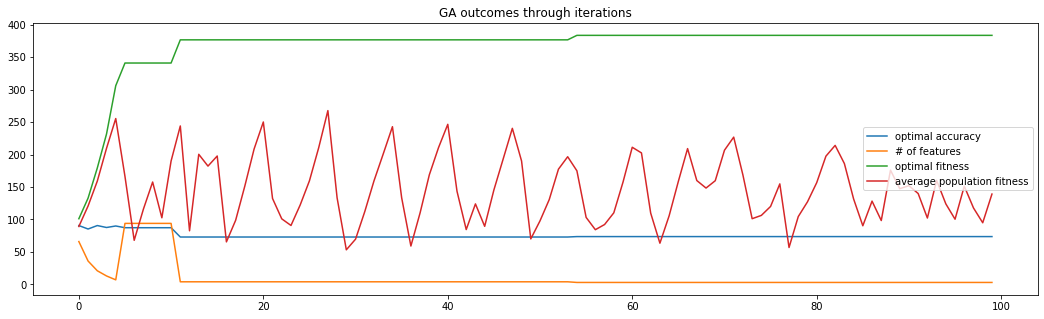

Final solution feature relevance: 
Feature: 97  Score: -0.59351
Feature: 196  Score: -0.20332
Feature: 199  Score: -0.01792


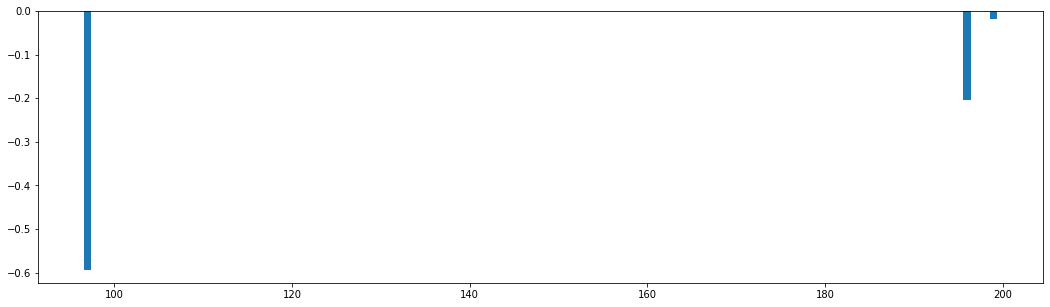

Trial  2
FINAL Optimal Feature Set
 [40, 97, 194]
FINAL Optimal Accuracy = 85.0 %
Execution time is:  24.908735036849976
Number of selected features is:  3
Number of features selected through iterations: 


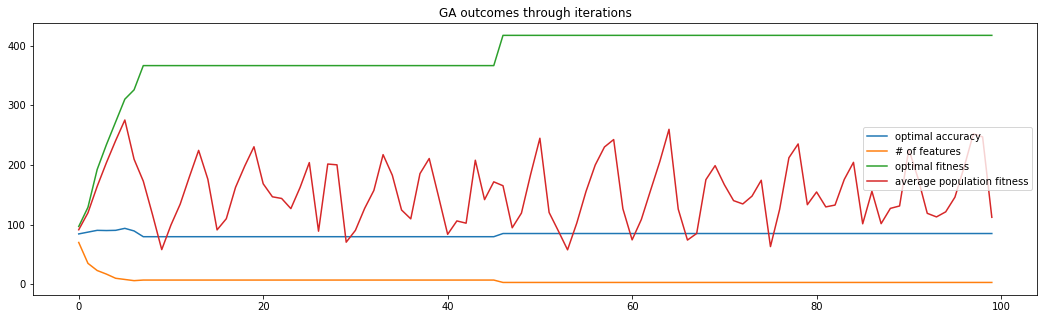

Final solution feature relevance: 
Feature: 40  Score: 0.80507
Feature: 97  Score: -0.68248
Feature: 194  Score: 0.06025


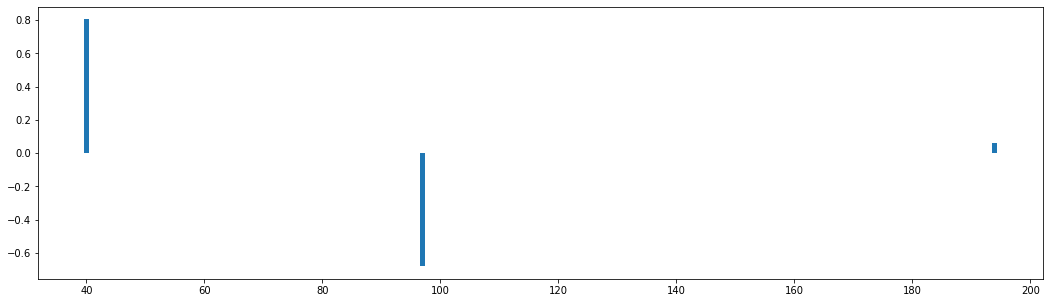

Trial  3
FINAL Optimal Feature Set
 [40, 97, 198]
FINAL Optimal Accuracy = 83.0 %
Execution time is:  25.341799020767212
Number of selected features is:  3
Number of features selected through iterations: 


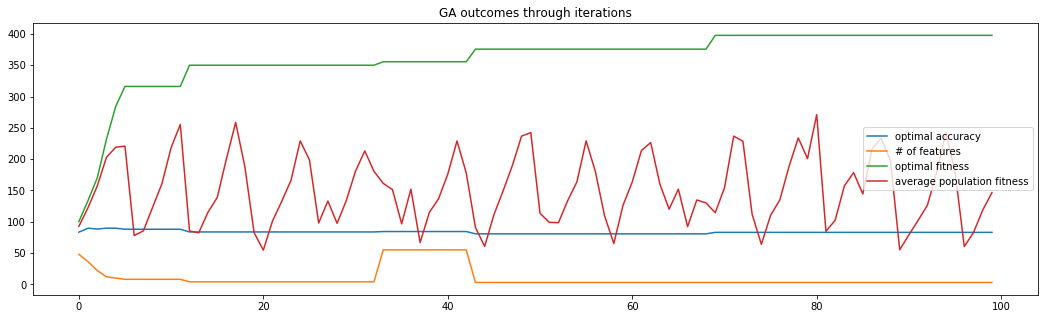

Final solution feature relevance: 
Feature: 40  Score: 0.90495
Feature: 97  Score: -0.70867
Feature: 198  Score: 0.03204


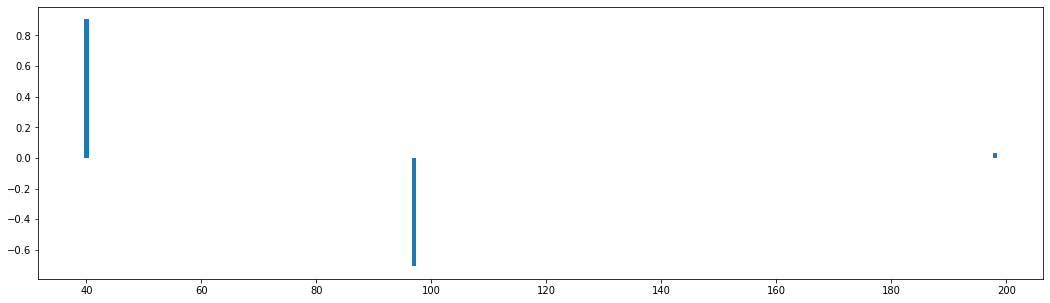

Trial  4
FINAL Optimal Feature Set
 [97, 177, 199]
FINAL Optimal Accuracy = 81.66666666666667 %
Execution time is:  24.423178911209106
Number of selected features is:  3
Number of features selected through iterations: 


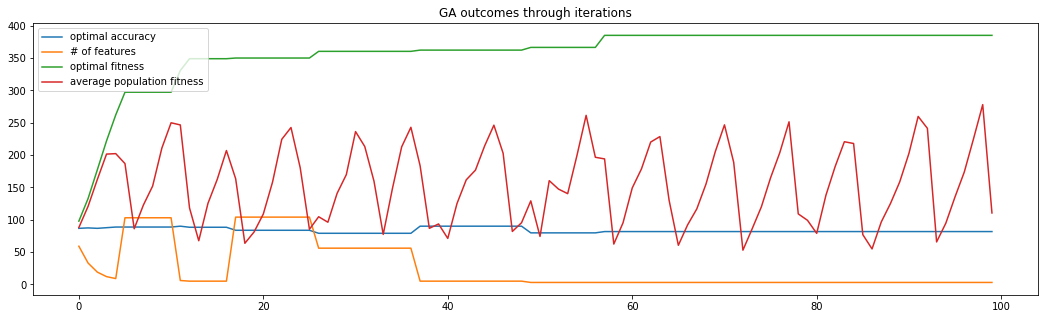

Final solution feature relevance: 
Feature: 97  Score: -0.75089
Feature: 177  Score: 0.67571
Feature: 199  Score: 0.04950


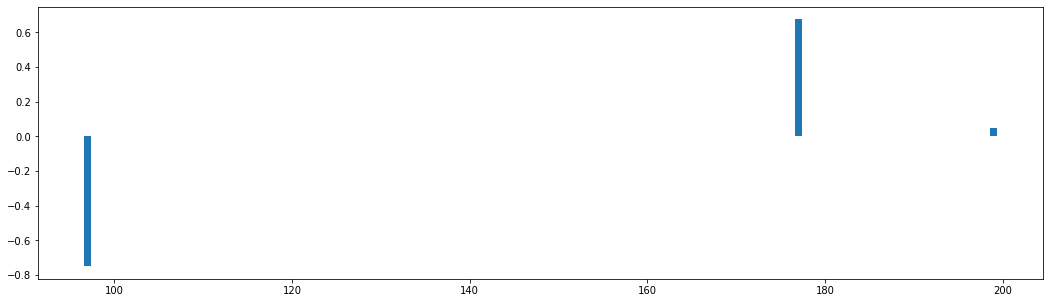

Trial  5
FINAL Optimal Feature Set
 [40, 53, 58, 59, 70, 87, 89, 114, 118, 121, 126, 135, 137, 138, 140, 141, 145, 146, 148, 150, 161, 164, 166, 171, 175, 176, 177, 179, 180, 181, 183, 186, 187, 191, 193, 194, 199]
FINAL Optimal Accuracy = 83.66666666666667 %
Execution time is:  23.98674488067627
Number of selected features is:  37
Number of features selected through iterations: 


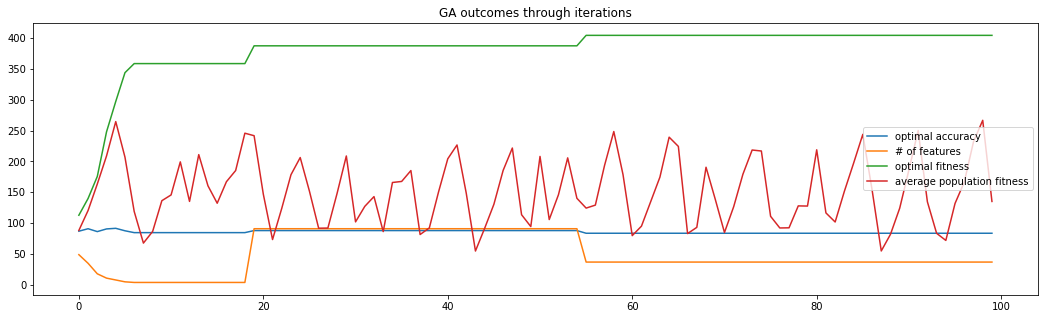

Final solution feature relevance: 
Feature: 40  Score: 0.54011
Feature: 53  Score: 0.37267
Feature: 58  Score: -0.09117
Feature: 59  Score: -0.34282
Feature: 70  Score: 0.01376
Feature: 87  Score: -0.13989
Feature: 89  Score: 0.00891
Feature: 114  Score: 0.21904
Feature: 118  Score: 0.02104
Feature: 121  Score: 0.09064
Feature: 126  Score: 0.17770
Feature: 135  Score: 0.58975
Feature: 137  Score: 0.05478
Feature: 138  Score: 0.03207
Feature: 140  Score: 0.08663
Feature: 141  Score: 0.08589
Feature: 145  Score: 0.32985
Feature: 146  Score: -0.01785
Feature: 148  Score: 0.19952
Feature: 150  Score: -0.02527
Feature: 161  Score: -0.00734
Feature: 164  Score: -0.09977
Feature: 166  Score: -0.00500
Feature: 171  Score: -0.01425
Feature: 175  Score: -0.03850
Feature: 176  Score: -0.19793
Feature: 177  Score: 0.67303
Feature: 179  Score: 0.24997
Feature: 180  Score: -0.14885
Feature: 181  Score: -0.00197
Feature: 183  Score: 0.01567
Feature: 186  Score: -0.07812
Feature: 187  Score: -0.06489


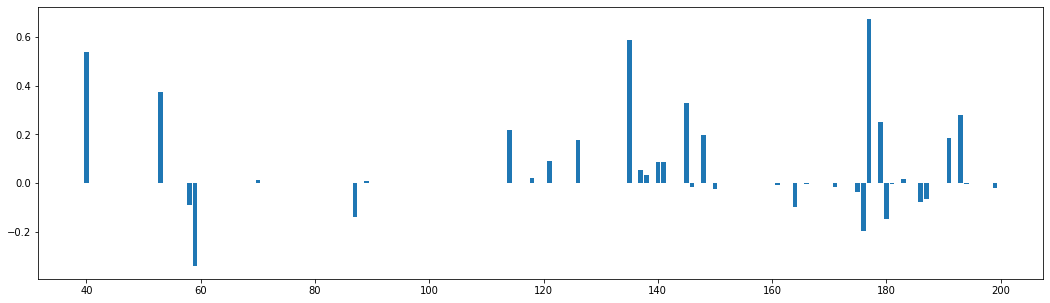

Trial  6
FINAL Optimal Feature Set
 [40, 97, 177, 198]
FINAL Optimal Accuracy = 90.0 %
Execution time is:  24.726567029953003
Number of selected features is:  4
Number of features selected through iterations: 


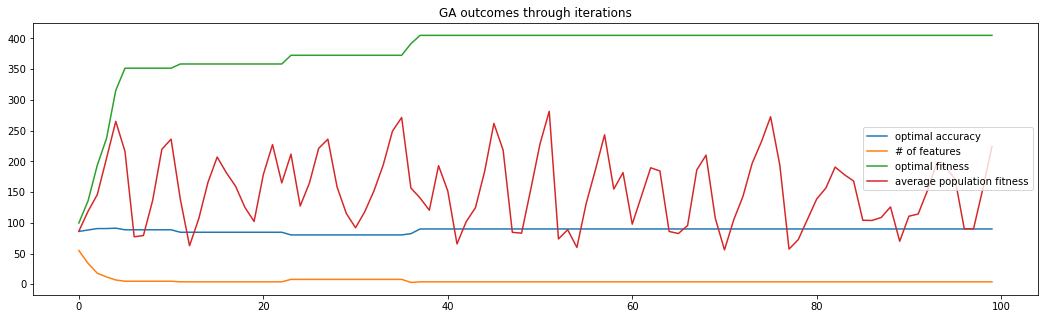

Final solution feature relevance: 
Feature: 40  Score: 0.74904
Feature: 97  Score: -0.86638
Feature: 177  Score: 0.62527
Feature: 198  Score: 0.11916


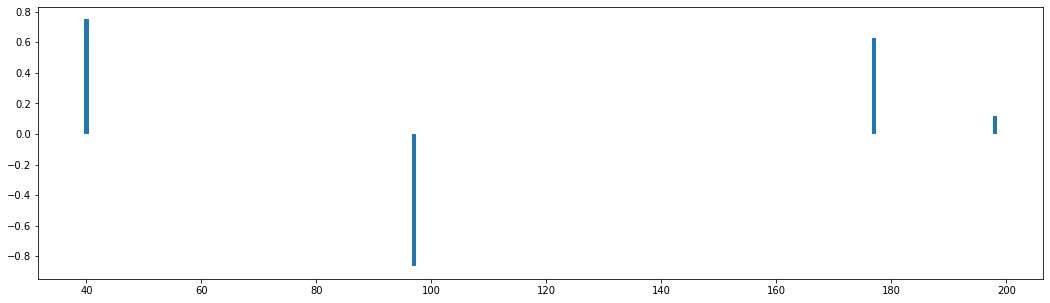

Trial  7
FINAL Optimal Feature Set
 [40, 192, 196, 198]
FINAL Optimal Accuracy = 76.66666666666667 %
Execution time is:  24.697885751724243
Number of selected features is:  4
Number of features selected through iterations: 


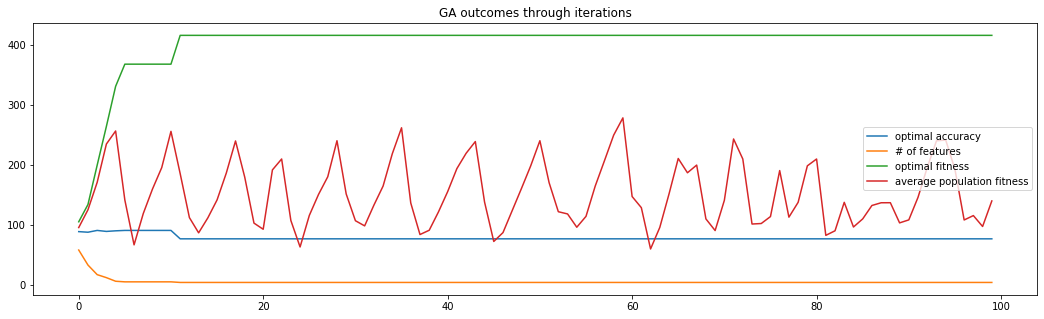

Final solution feature relevance: 
Feature: 40  Score: 0.67107
Feature: 192  Score: -0.06190
Feature: 196  Score: -0.15004
Feature: 198  Score: 0.05101


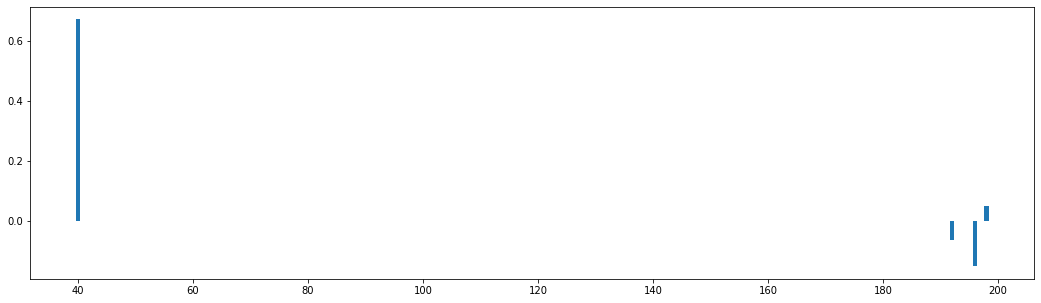

Trial  8
FINAL Optimal Feature Set
 [40, 97, 199]
FINAL Optimal Accuracy = 82.66666666666667 %
Execution time is:  24.5712308883667
Number of selected features is:  3
Number of features selected through iterations: 


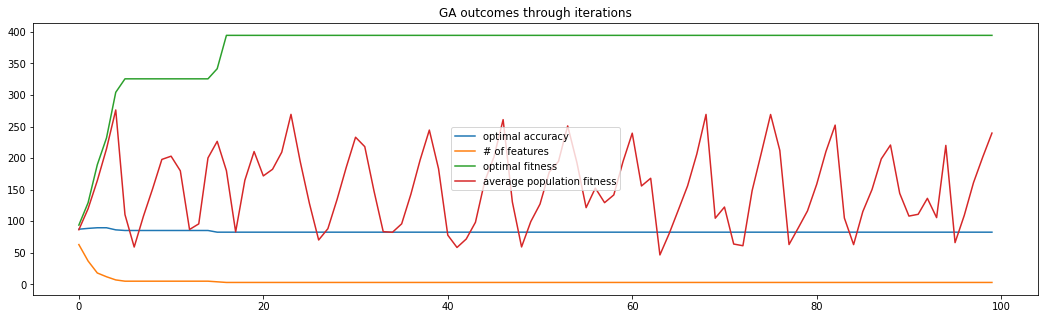

Final solution feature relevance: 
Feature: 40  Score: 0.84347
Feature: 97  Score: -0.68566
Feature: 199  Score: 0.00765


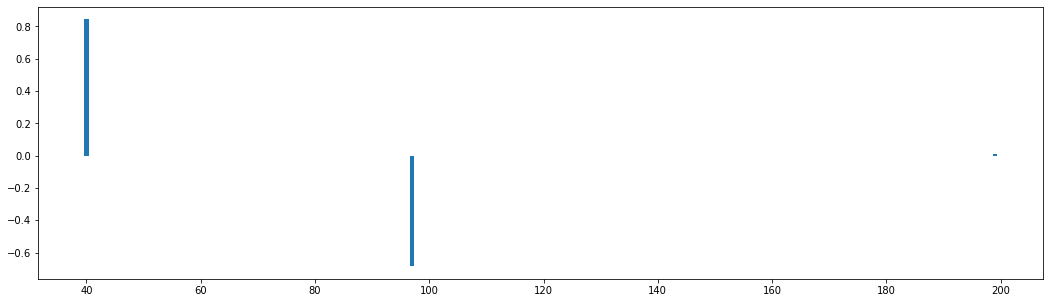

Trial  9
FINAL Optimal Feature Set
 [135, 177, 198]
FINAL Optimal Accuracy = 83.33333333333334 %
Execution time is:  24.560467958450317
Number of selected features is:  3
Number of features selected through iterations: 


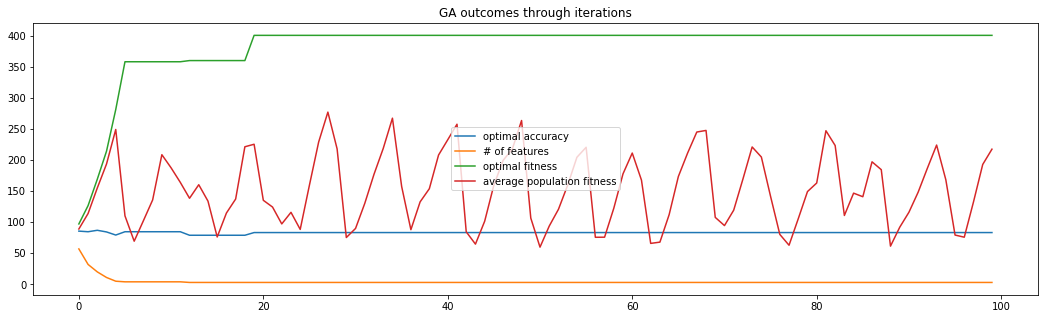

Final solution feature relevance: 
Feature: 135  Score: 0.72778
Feature: 177  Score: 0.71089
Feature: 198  Score: -0.00429


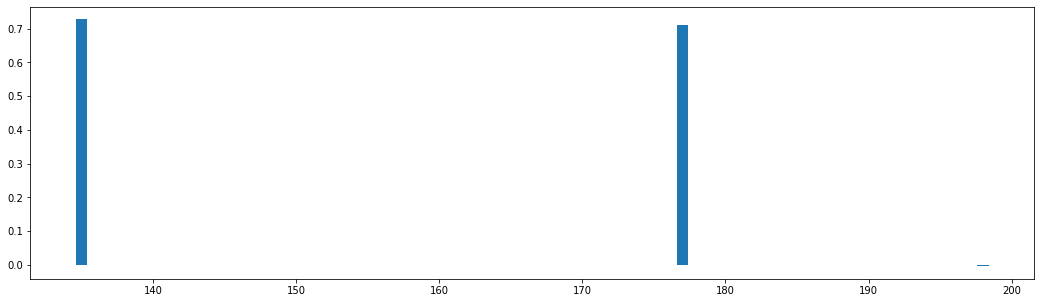

Trial  10
FINAL Optimal Feature Set
 [40, 97, 177, 199]
FINAL Optimal Accuracy = 87.0 %
Execution time is:  24.774386882781982
Number of selected features is:  4
Number of features selected through iterations: 


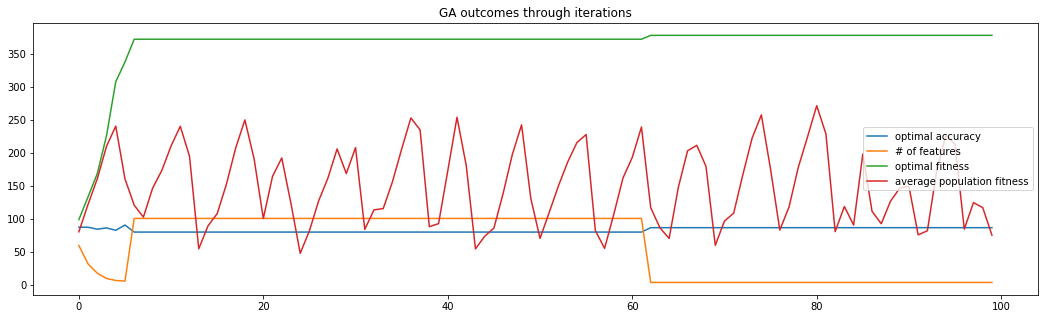

Final solution feature relevance: 
Feature: 40  Score: 0.74911
Feature: 97  Score: -0.84867
Feature: 177  Score: 0.63978
Feature: 199  Score: 0.11744


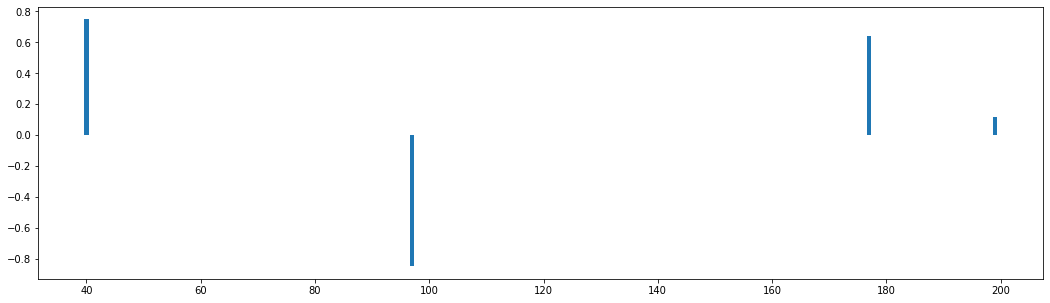

--------------------------------------------------
Average accuracy:  82.66666666666667
Average execution time:  247.06630444526672
Average number of features selected:  6.7


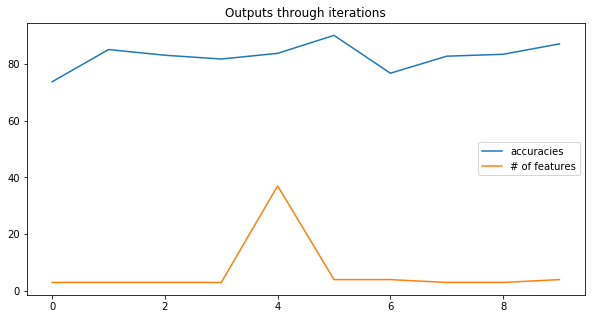

In [11]:
ga_multiple_trials(10, df1, feature_list, target, 10, 100)

Trial  1
FINAL Optimal Feature Set
 [27, 65, 100, 127, 163, 165, 186, 197, 198]
FINAL Optimal Accuracy = 75.33333333333333 %
Execution time is:  65.04367303848267
Number of selected features is:  9
Number of features selected through iterations: 


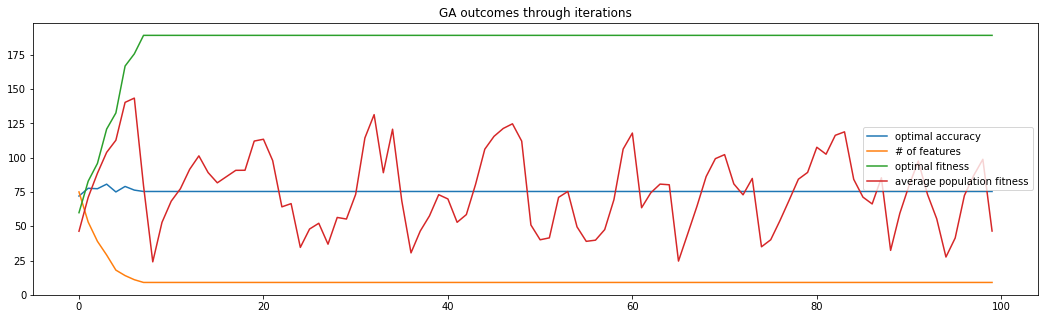

Final solution feature relevance: 
Feature: 27  Score: -0.79351
Feature: 65  Score: -0.50489
Feature: 100  Score: -0.37146
Feature: 127  Score: -0.29399
Feature: 163  Score: 0.65372
Feature: 165  Score: -0.61637
Feature: 186  Score: 0.57898
Feature: 197  Score: -0.04633
Feature: 198  Score: 0.69456


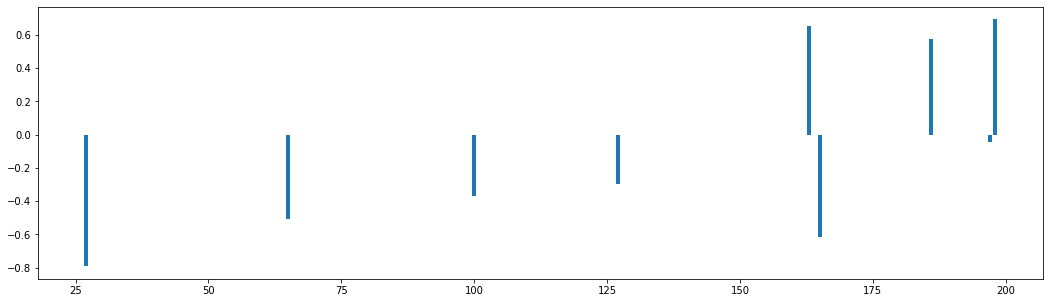

Trial  2
FINAL Optimal Feature Set
 [100, 163, 165, 174, 186, 196, 198]
FINAL Optimal Accuracy = 71.33333333333334 %
Execution time is:  66.04450011253357
Number of selected features is:  7
Number of features selected through iterations: 


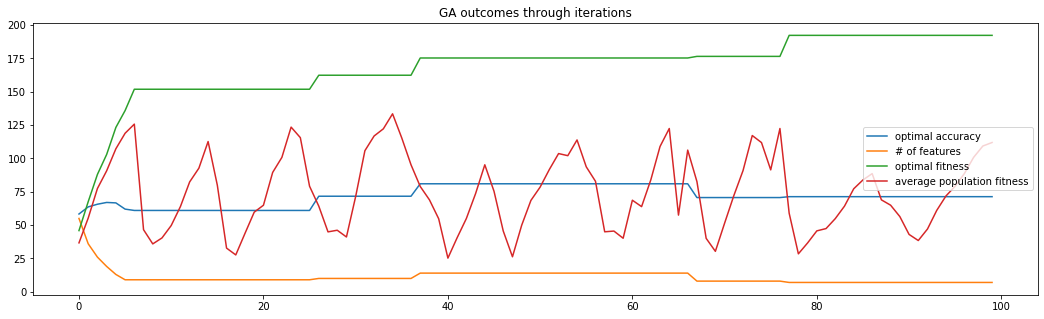

Final solution feature relevance: 
Feature: 100  Score: -0.38220
Feature: 163  Score: 0.51720
Feature: 165  Score: -0.52294
Feature: 174  Score: -1.27997
Feature: 186  Score: 0.56302
Feature: 196  Score: -0.08452
Feature: 198  Score: 0.59080


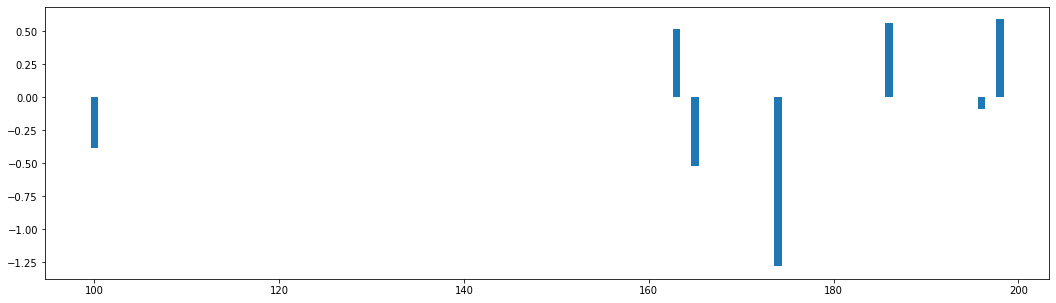

Trial  3
FINAL Optimal Feature Set
 [27, 65, 97, 100, 127, 163, 165, 174, 184, 196, 198]
FINAL Optimal Accuracy = 80.66666666666666 %
Execution time is:  67.50419187545776
Number of selected features is:  11
Number of features selected through iterations: 


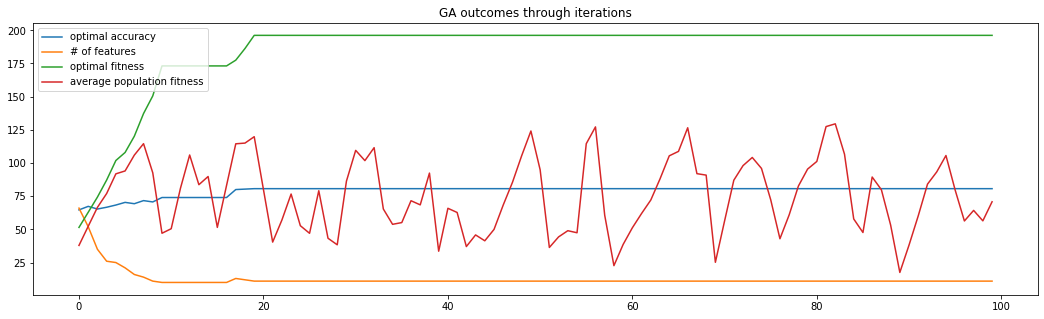

Final solution feature relevance: 
Feature: 27  Score: -0.79258
Feature: 65  Score: -0.65958
Feature: 97  Score: -0.37155
Feature: 100  Score: -0.57950
Feature: 127  Score: -0.16850
Feature: 163  Score: 0.66205
Feature: 165  Score: -0.91126
Feature: 174  Score: -1.36644
Feature: 184  Score: 0.19889
Feature: 196  Score: 0.11446
Feature: 198  Score: 0.69583


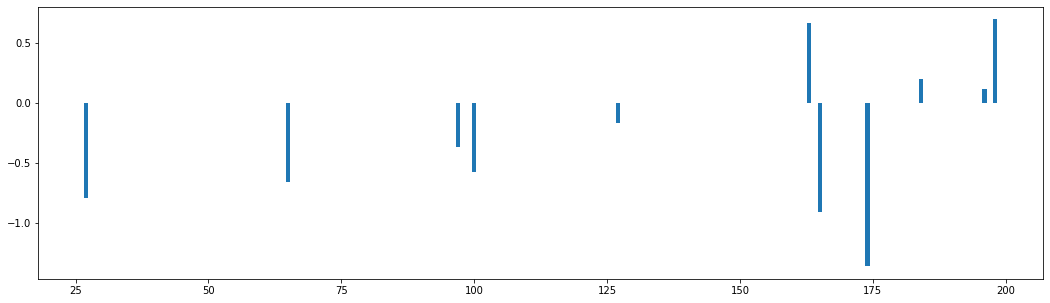

Trial  4
FINAL Optimal Feature Set
 [27, 65, 100, 127, 163, 165, 186, 198, 199]
FINAL Optimal Accuracy = 79.0 %
Execution time is:  65.00943183898926
Number of selected features is:  9
Number of features selected through iterations: 


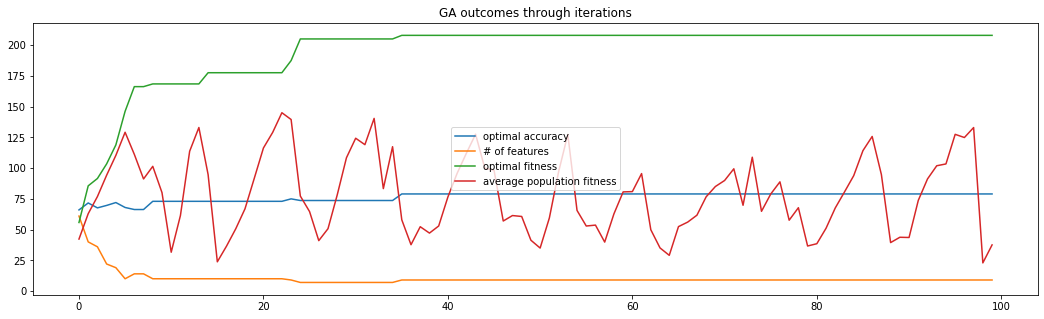

Final solution feature relevance: 
Feature: 27  Score: -0.74675
Feature: 65  Score: -0.51563
Feature: 100  Score: -0.41312
Feature: 127  Score: -0.23839
Feature: 163  Score: 0.60829
Feature: 165  Score: -0.52722
Feature: 186  Score: 0.63265
Feature: 198  Score: 0.74586
Feature: 199  Score: 0.06033


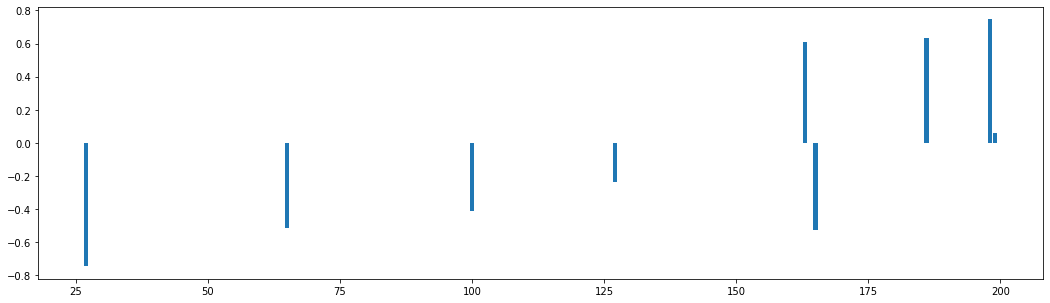

Trial  5
FINAL Optimal Feature Set
 [27, 65, 100, 163, 165, 186, 196, 198]
FINAL Optimal Accuracy = 75.0 %
Execution time is:  68.11558508872986
Number of selected features is:  8
Number of features selected through iterations: 


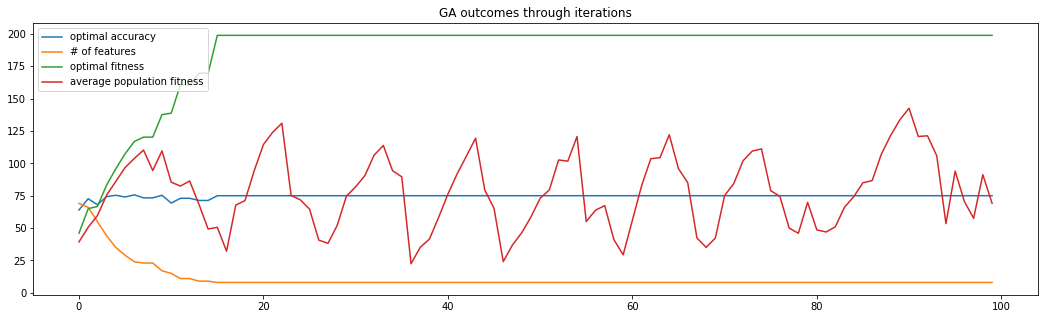

Final solution feature relevance: 
Feature: 27  Score: -0.65453
Feature: 65  Score: -0.47152
Feature: 100  Score: -0.28032
Feature: 163  Score: 0.64792
Feature: 165  Score: -0.42802
Feature: 186  Score: 0.59891
Feature: 196  Score: -0.03564
Feature: 198  Score: 0.61737


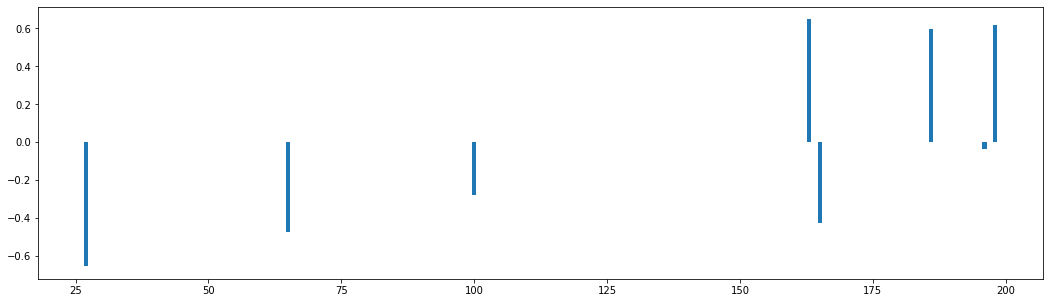

Trial  6
FINAL Optimal Feature Set
 [27, 65, 100, 127, 165, 186, 195, 198]
FINAL Optimal Accuracy = 74.0 %
Execution time is:  60.259026288986206
Number of selected features is:  8
Number of features selected through iterations: 


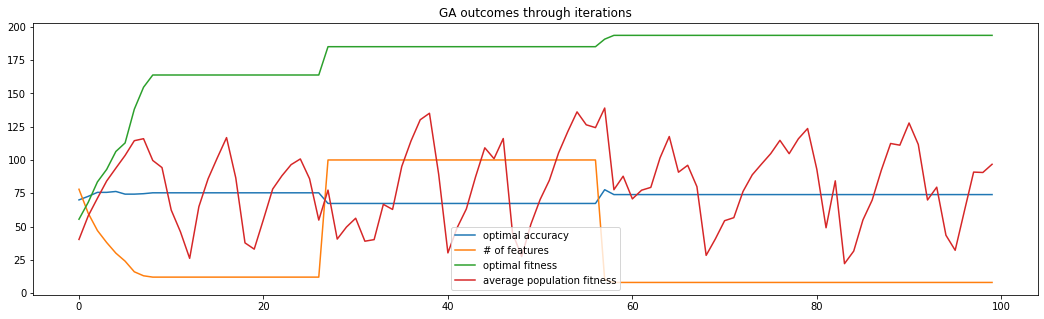

Final solution feature relevance: 
Feature: 27  Score: -0.62695
Feature: 65  Score: -0.42981
Feature: 100  Score: -0.33957
Feature: 127  Score: -0.12691
Feature: 165  Score: -0.36229
Feature: 186  Score: 0.59465
Feature: 195  Score: 0.03064
Feature: 198  Score: 0.48592


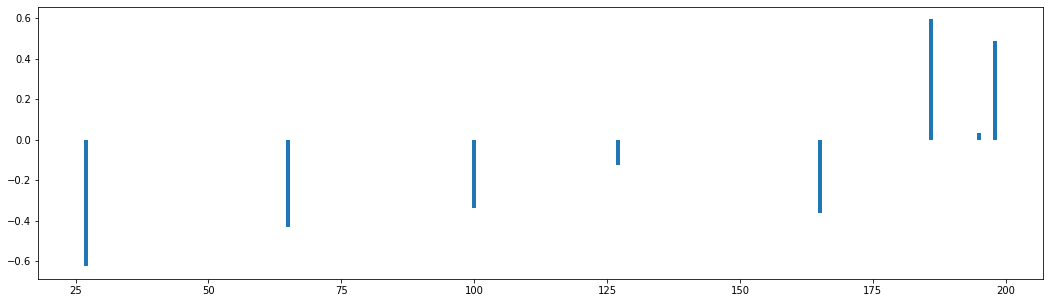

Trial  7
FINAL Optimal Feature Set
 [0, 1, 2, 4, 5, 6, 7, 11, 13, 15, 17, 19, 20, 21, 22, 24, 26, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 41, 42, 43, 45, 48, 49, 50, 54, 56, 61, 63, 64, 66, 68, 69, 74, 76, 78, 81, 83, 84, 85, 86, 87, 88, 92, 93, 94, 98, 102, 103, 104, 107, 108, 111, 112, 113, 116, 117, 127, 131, 133, 135, 136, 138, 140, 141, 142, 144, 145, 147, 148, 151, 152, 155, 156, 158, 159, 160, 162, 163, 165, 166, 167, 168, 171, 172, 174, 175, 177, 178, 184, 186, 196, 197, 198, 199]
FINAL Optimal Accuracy = 72.33333333333334 %
Execution time is:  59.67549395561218
Number of selected features is:  104
Number of features selected through iterations: 


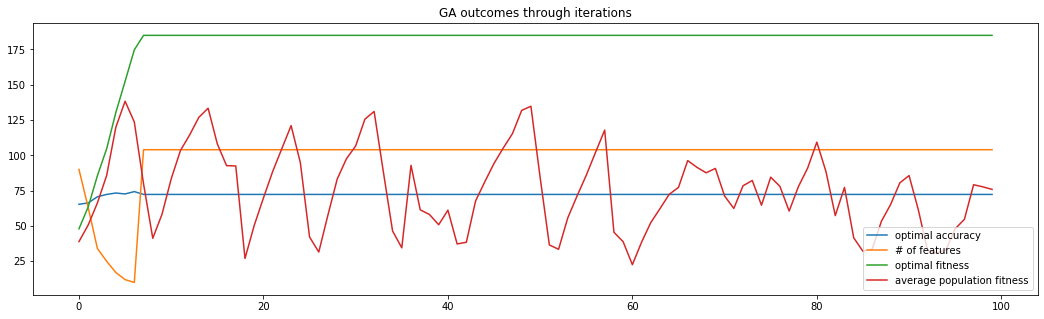

Final solution feature relevance: 
Feature: 0  Score: -0.14811
Feature: 1  Score: 0.05892
Feature: 2  Score: -0.13803
Feature: 4  Score: -0.03298
Feature: 5  Score: -0.02448
Feature: 6  Score: -0.16489
Feature: 7  Score: 0.30301
Feature: 11  Score: 0.16338
Feature: 13  Score: -0.28480
Feature: 15  Score: 0.20089
Feature: 17  Score: 0.11895
Feature: 19  Score: 0.00803
Feature: 20  Score: -0.19791
Feature: 21  Score: 0.02598
Feature: 22  Score: 0.01290
Feature: 24  Score: 0.42198
Feature: 26  Score: -0.00861
Feature: 29  Score: 0.06996
Feature: 30  Score: -0.40423
Feature: 31  Score: -0.00565
Feature: 32  Score: -0.12189
Feature: 33  Score: 0.26598
Feature: 34  Score: -0.05936
Feature: 35  Score: -0.12616
Feature: 36  Score: 0.28073
Feature: 37  Score: 0.22657
Feature: 39  Score: -0.56803
Feature: 41  Score: -0.31098
Feature: 42  Score: -0.14426
Feature: 43  Score: -0.18482
Feature: 45  Score: 0.21062
Feature: 48  Score: -0.23932
Feature: 49  Score: -0.38755
Feature: 50  Score: -0.15936


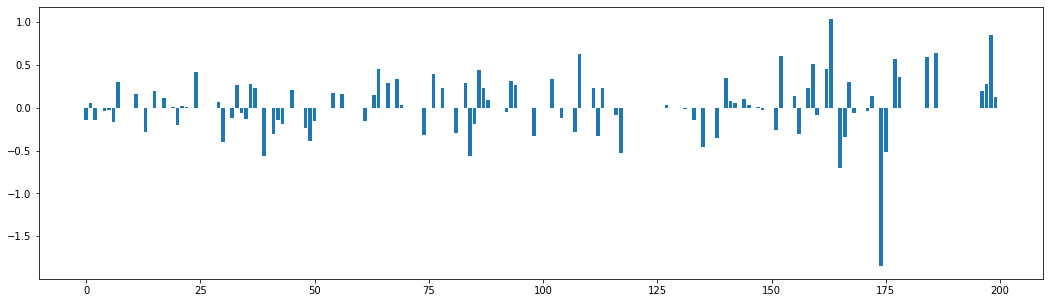

Trial  8
FINAL Optimal Feature Set
 [27, 65, 163, 165, 174, 184, 186, 197]
FINAL Optimal Accuracy = 72.33333333333334 %
Execution time is:  58.746121883392334
Number of selected features is:  8
Number of features selected through iterations: 


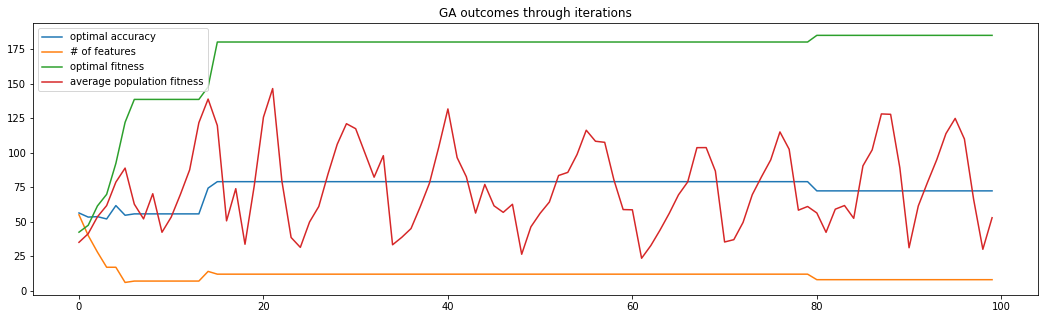

Final solution feature relevance: 
Feature: 27  Score: -0.57269
Feature: 65  Score: -0.67158
Feature: 163  Score: 0.73329
Feature: 165  Score: -0.93135
Feature: 174  Score: -1.28629
Feature: 184  Score: 0.37445
Feature: 186  Score: 0.33602
Feature: 197  Score: 0.36330


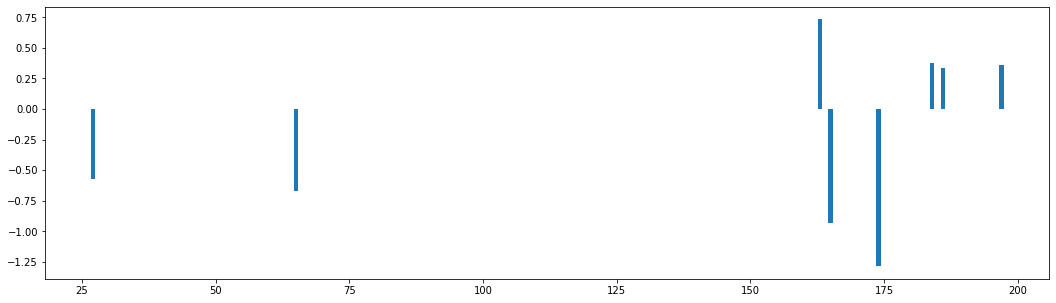

Trial  9
FINAL Optimal Feature Set
 [3, 4, 6, 9, 10, 13, 14, 18, 21, 22, 23, 24, 32, 37, 38, 39, 40, 41, 44, 45, 48, 49, 52, 53, 55, 56, 58, 59, 60, 61, 63, 65, 69, 70, 73, 74, 75, 77, 82, 83, 84, 85, 86, 91, 92, 94, 97, 98, 99, 100, 103, 105, 107, 108, 116, 117, 119, 122, 124, 125, 126, 129, 132, 134, 135, 138, 139, 140, 142, 143, 148, 154, 155, 156, 159, 163, 164, 166, 169, 175, 176, 178, 179, 180, 186, 193, 196, 197, 199]
FINAL Optimal Accuracy = 76.0 %
Execution time is:  59.44366693496704
Number of selected features is:  89
Number of features selected through iterations: 


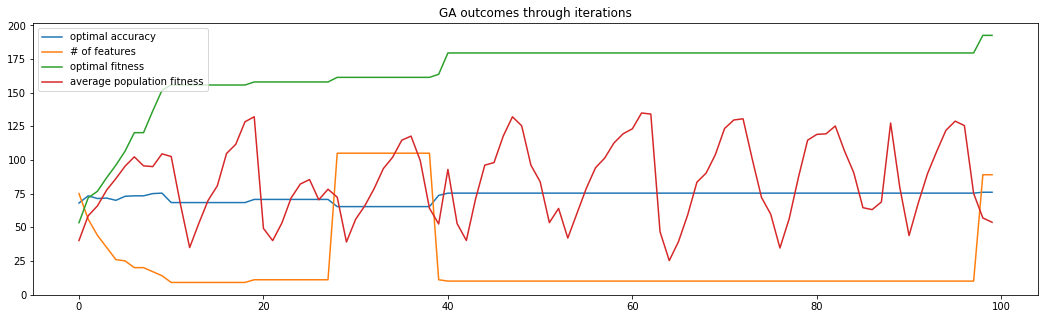

Final solution feature relevance: 
Feature: 3  Score: -0.01648
Feature: 4  Score: 0.11975
Feature: 6  Score: -0.10702
Feature: 9  Score: 0.15129
Feature: 10  Score: -0.28031
Feature: 13  Score: 0.10711
Feature: 14  Score: -0.05667
Feature: 18  Score: 0.00206
Feature: 21  Score: -0.12203
Feature: 22  Score: -0.00969
Feature: 23  Score: -0.14707
Feature: 24  Score: 0.15891
Feature: 32  Score: -0.12897
Feature: 37  Score: -0.28791
Feature: 38  Score: -0.05090
Feature: 39  Score: 0.06308
Feature: 40  Score: -0.03091
Feature: 41  Score: -0.11393
Feature: 44  Score: -0.03800
Feature: 45  Score: 0.03834
Feature: 48  Score: -0.08951
Feature: 49  Score: -0.05168
Feature: 52  Score: -0.06633
Feature: 53  Score: 0.25821
Feature: 55  Score: -0.03123
Feature: 56  Score: 0.10908
Feature: 58  Score: -0.12191
Feature: 59  Score: 0.00407
Feature: 60  Score: -0.16487
Feature: 61  Score: 0.01448
Feature: 63  Score: 0.33606
Feature: 65  Score: -0.50368
Feature: 69  Score: -0.08965
Feature: 70  Score: 0.06

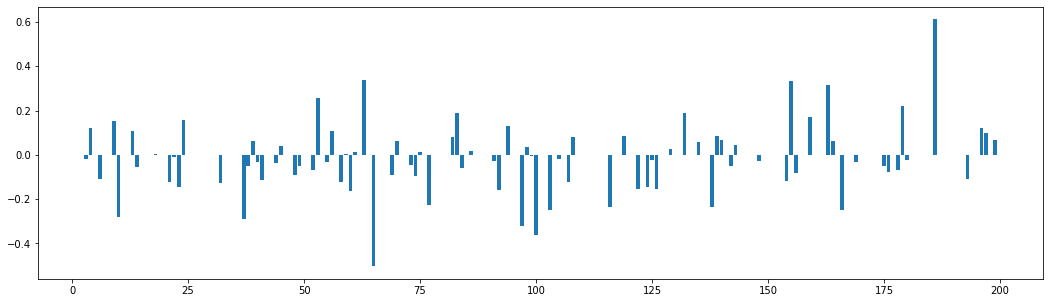

Trial  10
FINAL Optimal Feature Set
 [27, 87, 100, 163, 165, 174, 186, 198, 199]
FINAL Optimal Accuracy = 73.33333333333333 %
Execution time is:  58.650917053222656
Number of selected features is:  9
Number of features selected through iterations: 


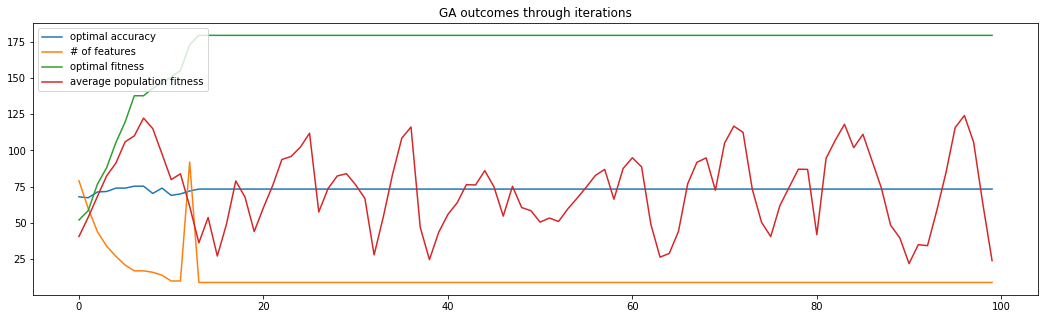

Final solution feature relevance: 
Feature: 27  Score: -0.80064
Feature: 87  Score: 0.27140
Feature: 100  Score: -0.38358
Feature: 163  Score: 0.61974
Feature: 165  Score: -0.51948
Feature: 174  Score: -1.19394
Feature: 186  Score: 0.48858
Feature: 198  Score: 0.76734
Feature: 199  Score: 0.20326


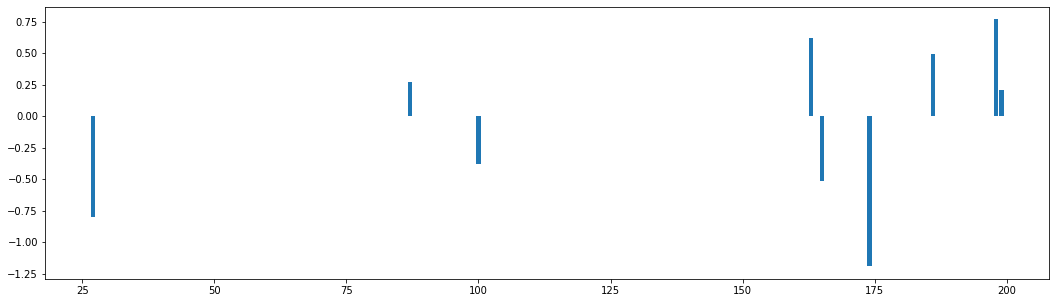

--------------------------------------------------
Average accuracy:  74.93333333333335
Average execution time:  628.4926080703735
Average number of features selected:  26.2


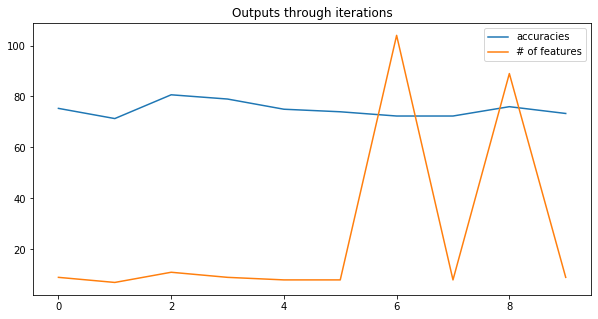

In [12]:
ga_multiple_trials(10, df2, feature_list2, target2, 10, 100)

Trial  1
FINAL Optimal Feature Set
 [452, 999, 1000]
FINAL Optimal Accuracy = 100.0 %
Execution time is:  176.17587900161743
Number of selected features is:  3
Number of features selected through iterations: 


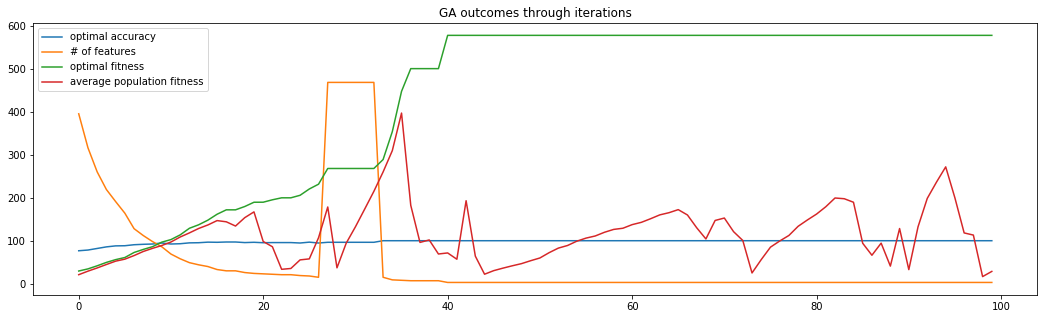

Final solution feature relevance: 
Feature: 452  Score: -0.09620
Feature: 999  Score: -0.03149
Feature: 1000  Score: -6.67713


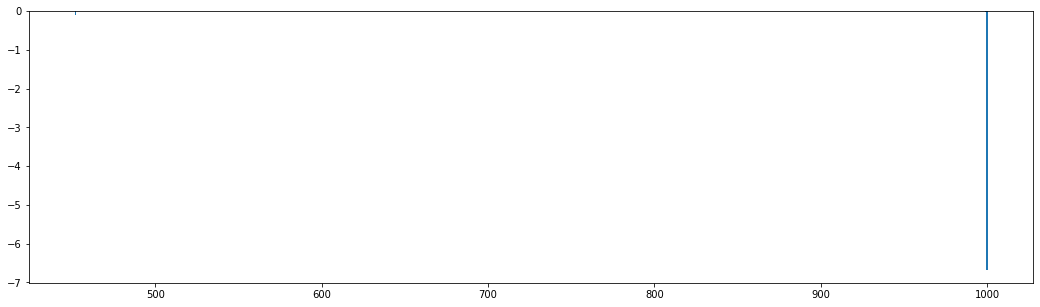

Trial  2
FINAL Optimal Feature Set
 [5, 33, 338, 564, 578, 709, 870, 888, 996, 997, 1000]
FINAL Optimal Accuracy = 96.66666666666667 %
Execution time is:  179.424556016922
Number of selected features is:  11
Number of features selected through iterations: 


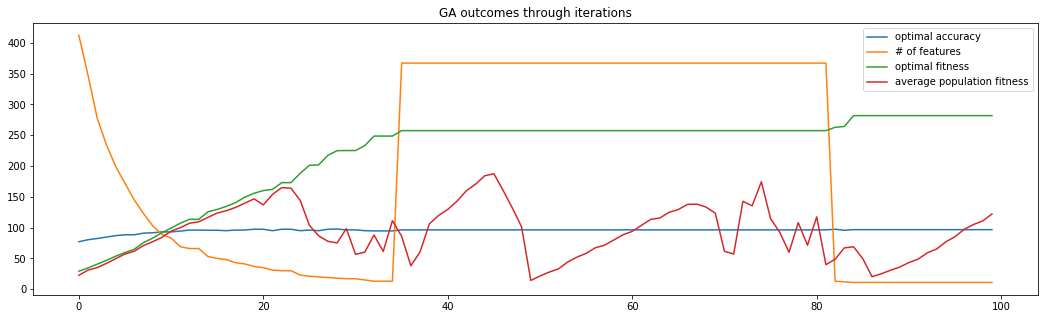

Final solution feature relevance: 
Feature: 5  Score: -0.34455
Feature: 33  Score: -0.11009
Feature: 338  Score: -1.12632
Feature: 564  Score: -0.12290
Feature: 578  Score: -0.21626
Feature: 709  Score: -0.17664
Feature: 870  Score: -0.18344
Feature: 888  Score: -0.10977
Feature: 996  Score: 0.08204
Feature: 997  Score: -0.21430
Feature: 1000  Score: -5.76506


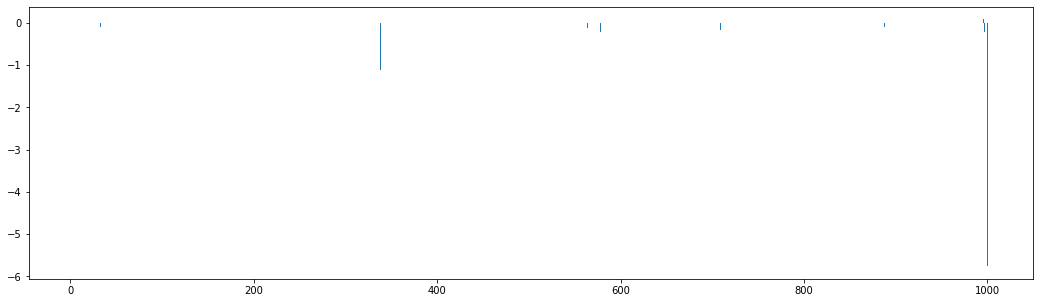

Trial  3
FINAL Optimal Feature Set
 [5, 100, 323, 338, 578, 673, 984, 997, 999, 1000]
FINAL Optimal Accuracy = 96.0 %
Execution time is:  159.56163382530212
Number of selected features is:  10
Number of features selected through iterations: 


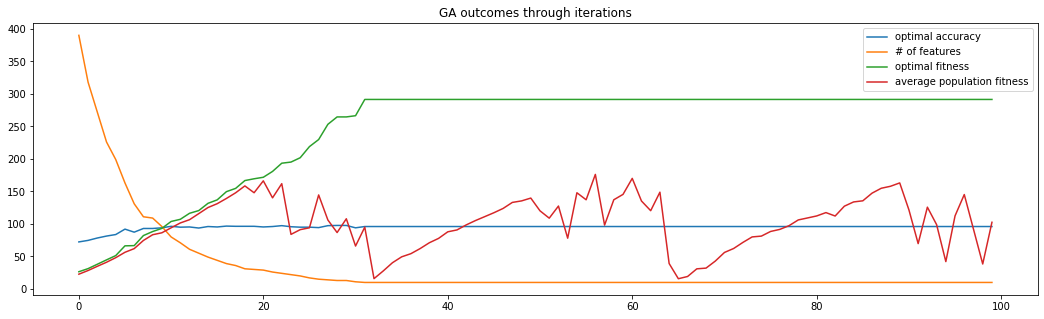

Final solution feature relevance: 
Feature: 5  Score: -0.26954
Feature: 100  Score: -0.13661
Feature: 323  Score: -0.18817
Feature: 338  Score: -1.10873
Feature: 578  Score: -0.13418
Feature: 673  Score: -0.16462
Feature: 984  Score: 0.19661
Feature: 997  Score: -0.11422
Feature: 999  Score: 0.09259
Feature: 1000  Score: -5.79343


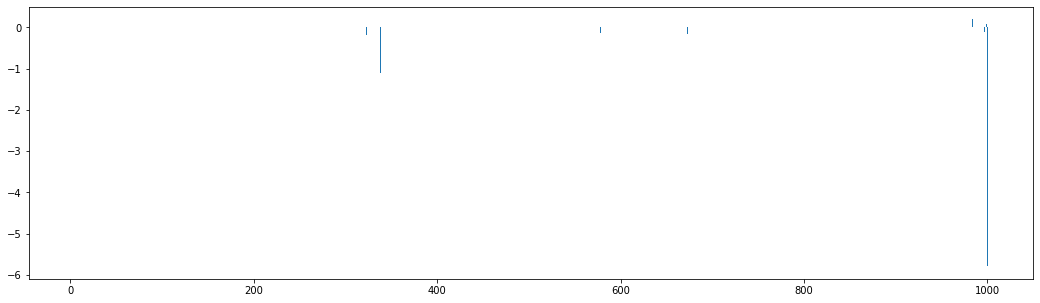

Trial  4
FINAL Optimal Feature Set
 [890, 934, 937, 958, 959, 960, 961, 964, 972, 973, 976, 984, 992, 997, 1000]
FINAL Optimal Accuracy = 100.0 %
Execution time is:  162.9157199859619
Number of selected features is:  15
Number of features selected through iterations: 


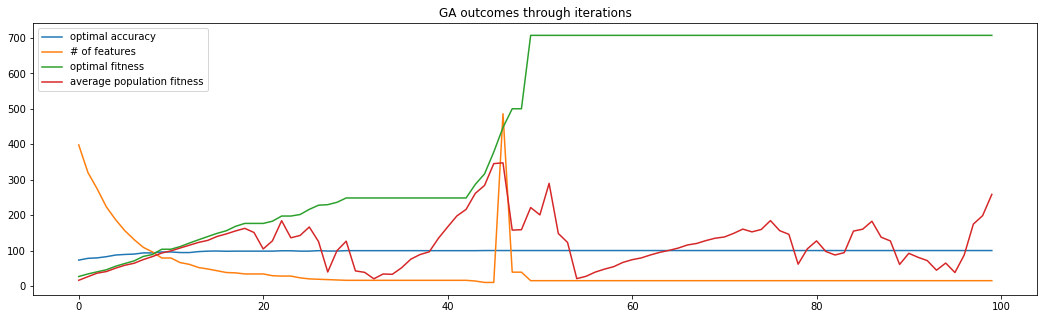

Final solution feature relevance: 
Feature: 890  Score: 0.07875
Feature: 934  Score: 0.07301
Feature: 937  Score: -0.01116
Feature: 958  Score: -0.02075
Feature: 959  Score: -0.02823
Feature: 960  Score: 0.05449
Feature: 961  Score: 0.00573
Feature: 964  Score: -0.05032
Feature: 972  Score: 0.00192
Feature: 973  Score: 0.04818
Feature: 976  Score: 0.03552
Feature: 984  Score: 0.08774
Feature: 992  Score: -0.00955
Feature: 997  Score: -0.06834
Feature: 1000  Score: -6.59262


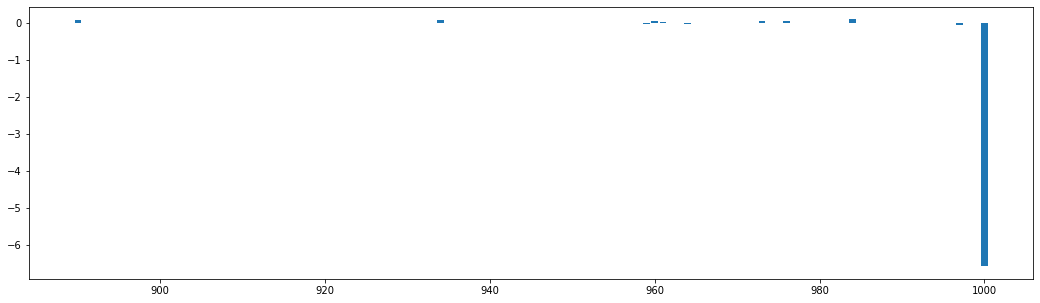

Trial  5
FINAL Optimal Feature Set
 [995, 996, 997, 1000]
FINAL Optimal Accuracy = 95.0 %
Execution time is:  185.42644476890564
Number of selected features is:  4
Number of features selected through iterations: 


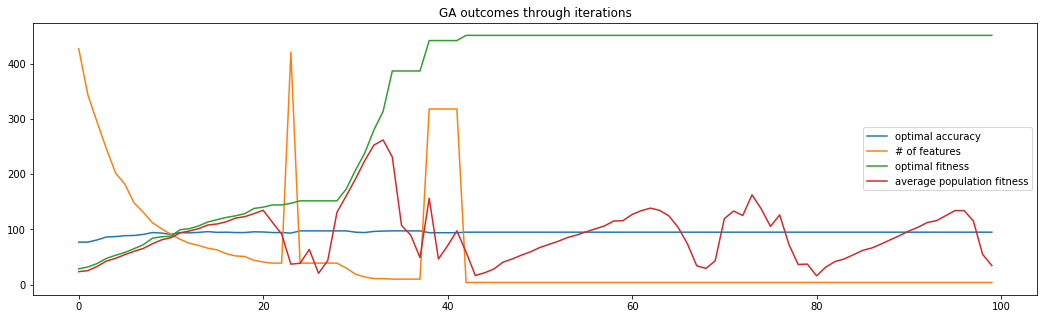

Final solution feature relevance: 
Feature: 995  Score: -0.02028
Feature: 996  Score: -0.17363
Feature: 997  Score: -0.14482
Feature: 1000  Score: -6.65796


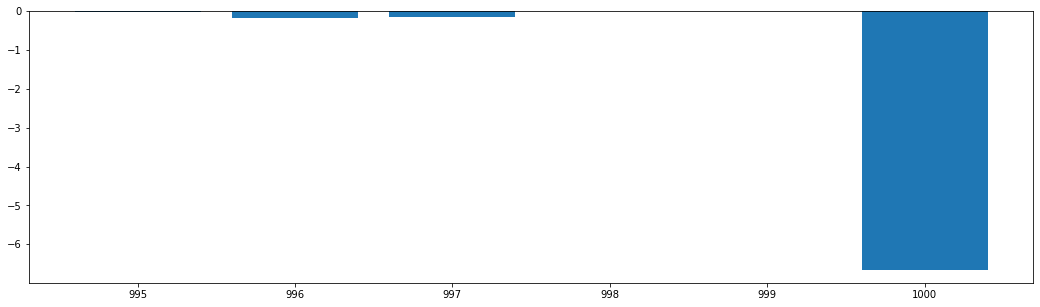

Trial  6
FINAL Optimal Feature Set
 [5, 96, 323, 338, 607, 709, 762, 807, 825, 843, 888, 984, 999, 1000]
FINAL Optimal Accuracy = 96.0 %
Execution time is:  173.82402300834656
Number of selected features is:  14
Number of features selected through iterations: 


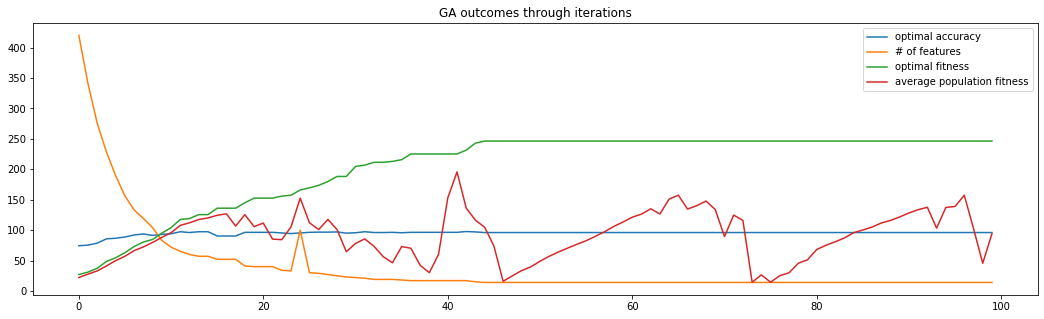

Final solution feature relevance: 
Feature: 5  Score: -0.23807
Feature: 96  Score: -0.28146
Feature: 323  Score: -0.36648
Feature: 338  Score: -1.32807
Feature: 607  Score: 0.20012
Feature: 709  Score: -0.26679
Feature: 762  Score: -0.15772
Feature: 807  Score: 0.07178
Feature: 825  Score: 0.24516
Feature: 843  Score: -0.04017
Feature: 888  Score: -0.16753
Feature: 984  Score: 0.23607
Feature: 999  Score: -0.04018
Feature: 1000  Score: -5.68891


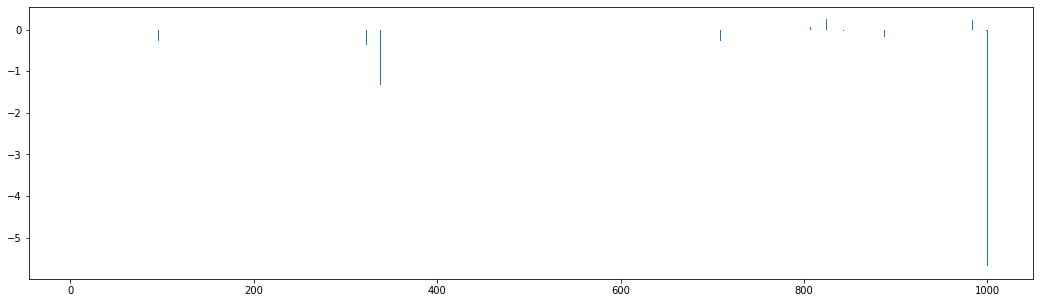

Trial  7
FINAL Optimal Feature Set
 [5, 94, 96, 275, 338, 356, 999, 1000]
FINAL Optimal Accuracy = 96.33333333333334 %
Execution time is:  172.36417818069458
Number of selected features is:  8
Number of features selected through iterations: 


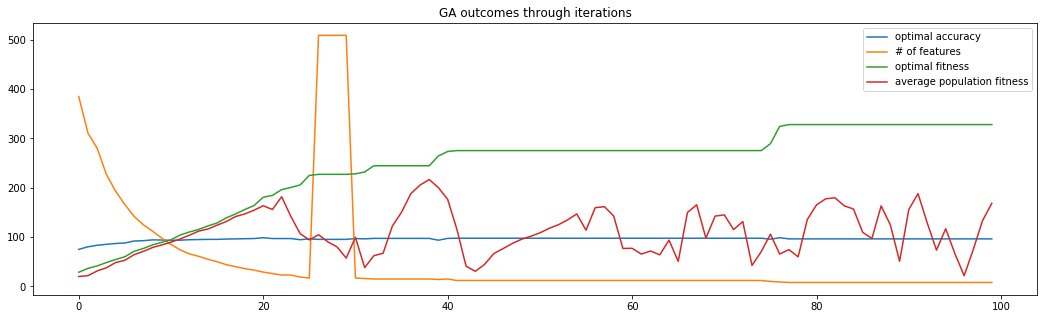

Final solution feature relevance: 
Feature: 5  Score: -0.29637
Feature: 94  Score: -0.17381
Feature: 96  Score: -0.29328
Feature: 275  Score: 0.16869
Feature: 338  Score: -1.08364
Feature: 356  Score: 0.13381
Feature: 999  Score: 0.03191
Feature: 1000  Score: -5.84639


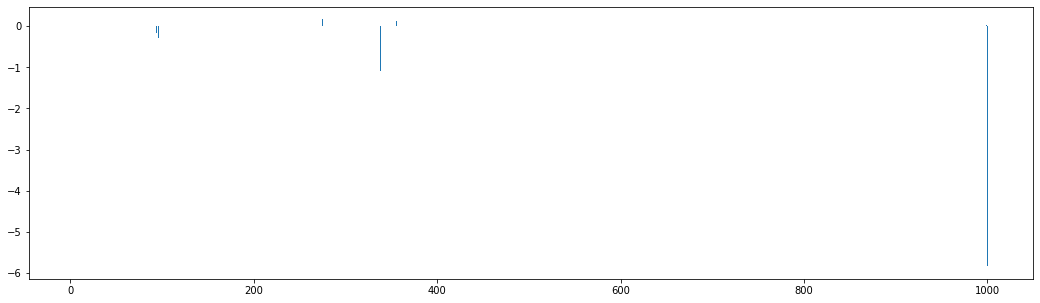

Trial  8
FINAL Optimal Feature Set
 [100, 998, 1000]
FINAL Optimal Accuracy = 100.0 %
Execution time is:  150.34513211250305
Number of selected features is:  3
Number of features selected through iterations: 


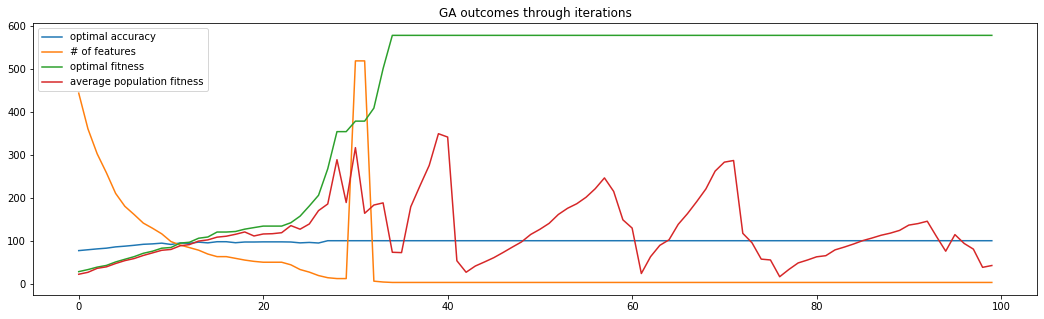

Final solution feature relevance: 
Feature: 100  Score: -0.11647
Feature: 998  Score: -0.01753
Feature: 1000  Score: -6.70588


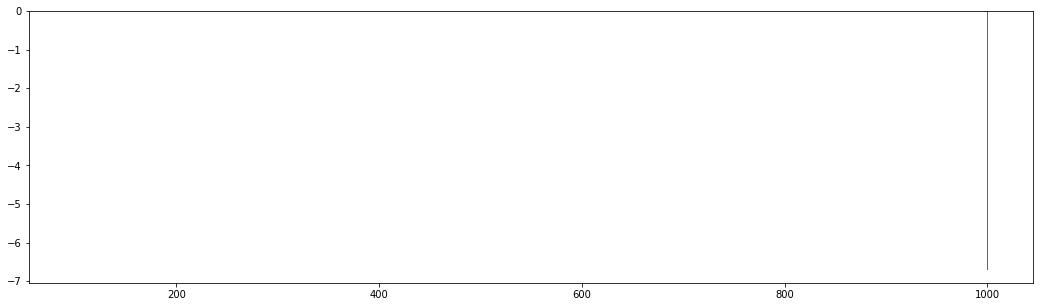

Trial  9
FINAL Optimal Feature Set
 [2, 3, 5, 6, 8, 9, 11, 14, 17, 18, 24, 27, 28, 29, 30, 35, 36, 37, 41, 42, 43, 44, 45, 49, 50, 53, 54, 57, 58, 59, 60, 61, 62, 65, 66, 67, 68, 69, 70, 73, 75, 77, 78, 79, 81, 84, 85, 87, 92, 94, 95, 96, 97, 100, 102, 103, 106, 107, 109, 110, 111, 113, 114, 115, 116, 118, 120, 121, 122, 126, 128, 129, 131, 134, 140, 142, 143, 144, 149, 150, 151, 153, 155, 156, 159, 161, 162, 164, 165, 166, 167, 172, 176, 178, 179, 180, 181, 185, 186, 188, 189, 190, 196, 197, 199, 201, 203, 204, 206, 212, 216, 217, 218, 219, 220, 221, 222, 228, 229, 231, 232, 234, 236, 237, 238, 239, 240, 242, 243, 244, 245, 248, 249, 251, 256, 258, 259, 264, 266, 268, 269, 270, 272, 275, 276, 279, 281, 282, 286, 287, 288, 294, 295, 296, 298, 300, 303, 305, 307, 308, 309, 311, 313, 314, 320, 321, 323, 324, 329, 331, 332, 333, 334, 335, 337, 344, 345, 346, 348, 350, 353, 355, 357, 359, 361, 364, 366, 367, 368, 374, 376, 380, 381, 383, 385, 386, 387, 389, 390, 392, 395, 396, 399, 402, 40

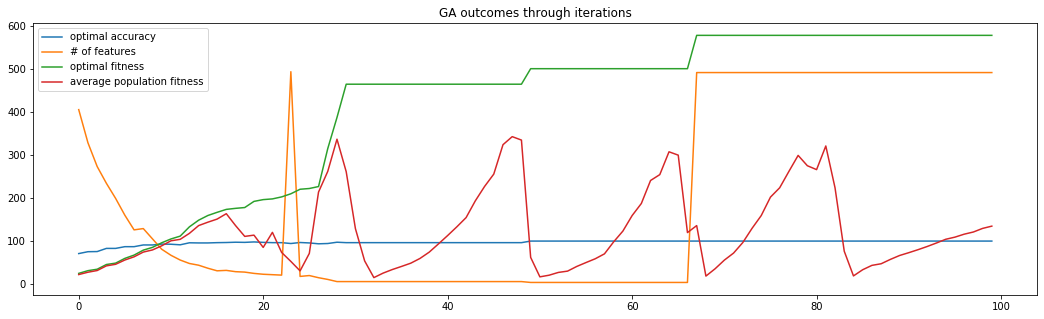

Final solution feature relevance: 
Feature: 2  Score: -0.40712
Feature: 3  Score: -0.46044
Feature: 5  Score: -1.13035
Feature: 6  Score: -0.12814
Feature: 8  Score: 0.06220
Feature: 9  Score: -0.14904
Feature: 11  Score: -0.56148
Feature: 14  Score: -0.00191
Feature: 17  Score: -0.37402
Feature: 18  Score: -0.03395
Feature: 24  Score: 0.04422
Feature: 27  Score: 0.12808
Feature: 28  Score: -0.02856
Feature: 29  Score: 0.21277
Feature: 30  Score: 0.16803
Feature: 35  Score: -0.20208
Feature: 36  Score: 0.63295
Feature: 37  Score: 0.43649
Feature: 41  Score: 0.17132
Feature: 42  Score: -0.24259
Feature: 43  Score: -0.04755
Feature: 44  Score: -0.56720
Feature: 45  Score: -0.07165
Feature: 49  Score: 0.14741
Feature: 50  Score: 0.50464
Feature: 53  Score: 0.17394
Feature: 54  Score: -0.03978
Feature: 57  Score: -0.12069
Feature: 58  Score: 0.08865
Feature: 59  Score: -0.00216
Feature: 60  Score: -0.30944
Feature: 61  Score: -0.02210
Feature: 62  Score: 0.74285
Feature: 65  Score: 0.08585

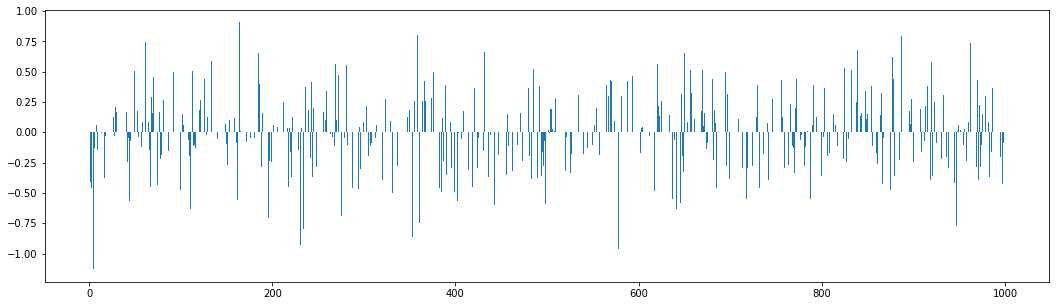

Trial  10
FINAL Optimal Feature Set
 [2, 18, 495, 614, 921, 927, 930, 933, 934, 936, 941, 943, 947, 949, 950, 954, 956, 961, 963, 964, 966, 967, 969, 970, 972, 973, 978, 979, 981, 983, 984, 988, 989, 992, 993, 994, 998]
FINAL Optimal Accuracy = 96.66666666666667 %
Execution time is:  164.66647505760193
Number of selected features is:  37
Number of features selected through iterations: 


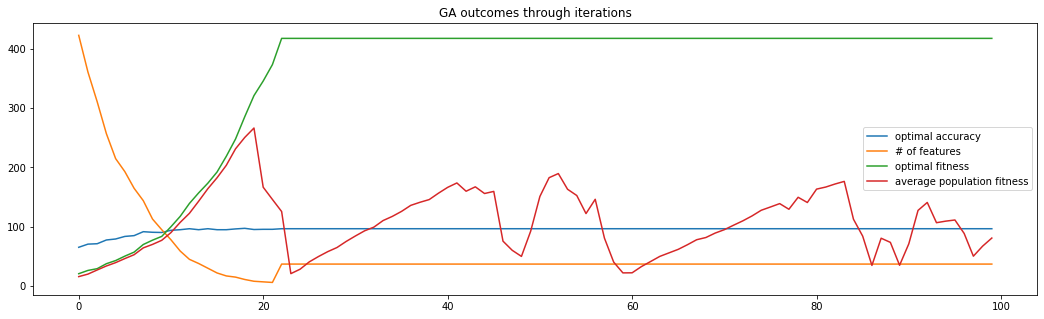

Final solution feature relevance: 
Feature: 2  Score: -0.14148
Feature: 18  Score: -0.05698
Feature: 495  Score: -0.31281
Feature: 614  Score: 0.09594
Feature: 921  Score: 0.00357
Feature: 927  Score: 0.03346
Feature: 930  Score: 0.02637
Feature: 933  Score: 0.06909
Feature: 934  Score: 0.18917
Feature: 936  Score: 0.00755
Feature: 941  Score: 0.05064
Feature: 943  Score: 0.12117
Feature: 947  Score: -0.05686
Feature: 949  Score: -0.04529
Feature: 950  Score: 0.02118
Feature: 954  Score: 0.01858
Feature: 956  Score: -0.01262
Feature: 961  Score: 0.04690
Feature: 963  Score: 0.11983
Feature: 964  Score: -0.13331
Feature: 966  Score: -0.00127
Feature: 967  Score: 0.10469
Feature: 969  Score: -0.09895
Feature: 970  Score: 0.07900
Feature: 972  Score: -0.05101
Feature: 973  Score: 0.05534
Feature: 978  Score: -0.05273
Feature: 979  Score: 0.12367
Feature: 981  Score: 0.02034
Feature: 983  Score: -0.05870
Feature: 984  Score: 0.04974
Feature: 988  Score: 0.07146
Feature: 989  Score: -0.1323

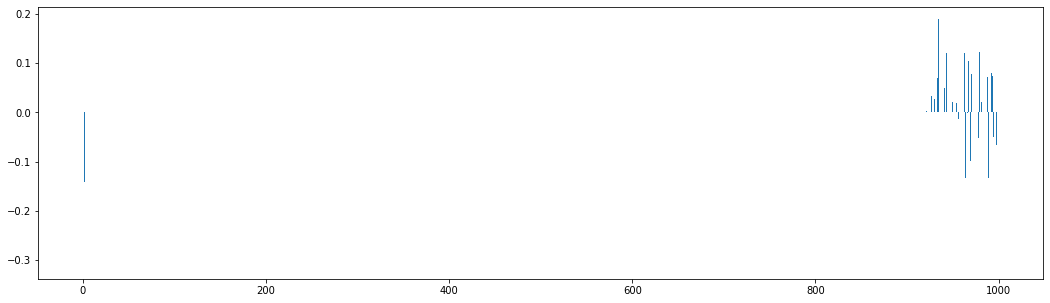

--------------------------------------------------
Average accuracy:  97.66666666666667
Average execution time:  1690.1047291755676
Average number of features selected:  59.6


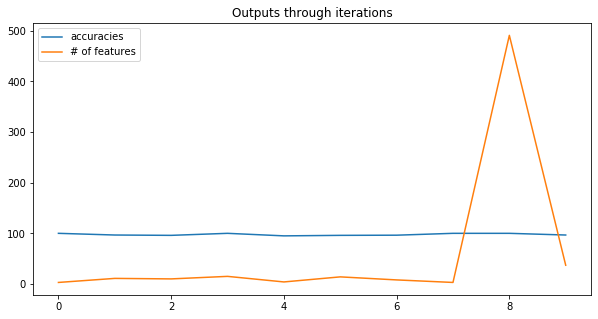

In [13]:
ga_multiple_trials(10, df3, feature_list3, target3, 10, 100)

Trial  1
FINAL Optimal Feature Set
 [47, 57, 75, 111, 114, 143, 199, 200]
FINAL Optimal Accuracy = 96.66666666666667 %
Execution time is:  82.63179993629456
Number of selected features is:  8
Number of features selected through iterations: 


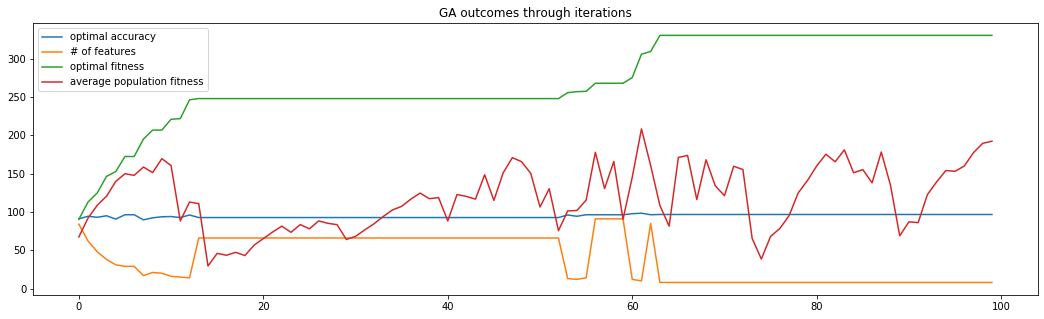

Final solution feature relevance: 
Feature: 47  Score: 0.02586
Feature: 57  Score: 1.08632
Feature: 75  Score: 0.13612
Feature: 111  Score: 0.17965
Feature: 114  Score: 0.69687
Feature: 143  Score: -0.12519
Feature: 199  Score: 0.06291
Feature: 200  Score: -2.10940


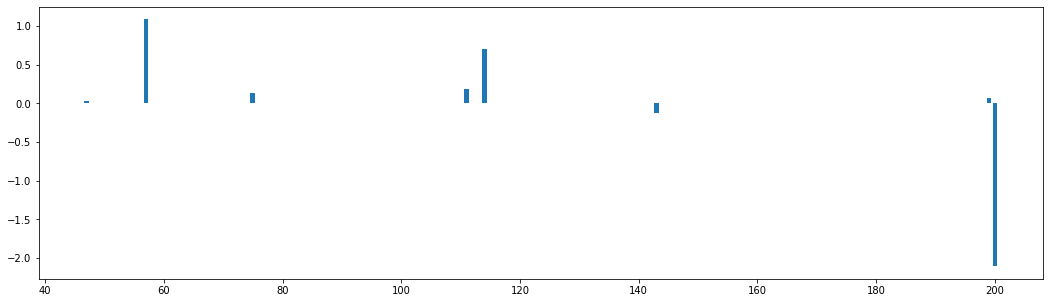

Trial  2
FINAL Optimal Feature Set
 [57, 114, 143, 149, 198, 200]
FINAL Optimal Accuracy = 92.33333333333333 %
Execution time is:  79.8840799331665
Number of selected features is:  6
Number of features selected through iterations: 


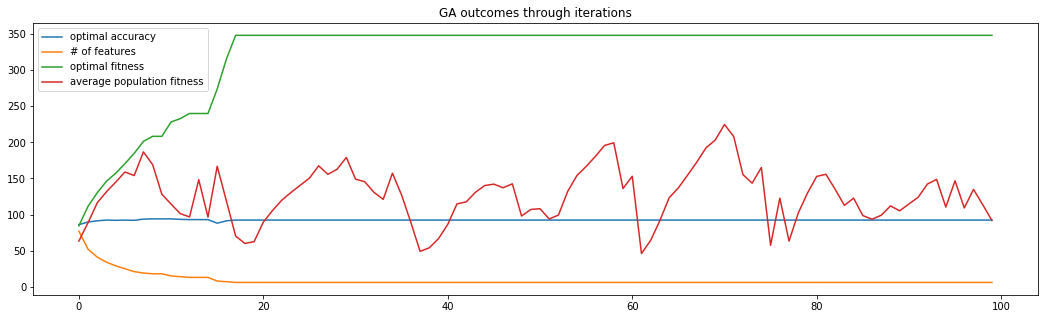

Final solution feature relevance: 
Feature: 57  Score: 1.02880
Feature: 114  Score: 0.55005
Feature: 143  Score: -0.10902
Feature: 149  Score: -0.08674
Feature: 198  Score: -0.05750
Feature: 200  Score: -2.38661


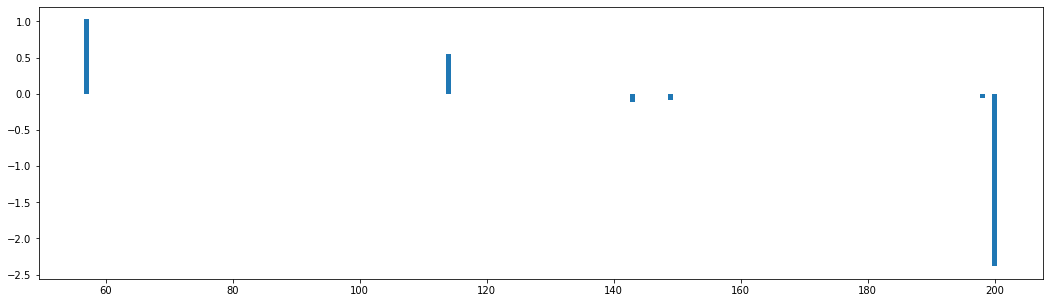

Trial  3
FINAL Optimal Feature Set
 [41, 57, 70, 75, 114, 149, 165, 188, 199, 200]
FINAL Optimal Accuracy = 97.33333333333334 %
Execution time is:  81.14366006851196
Number of selected features is:  10
Number of features selected through iterations: 


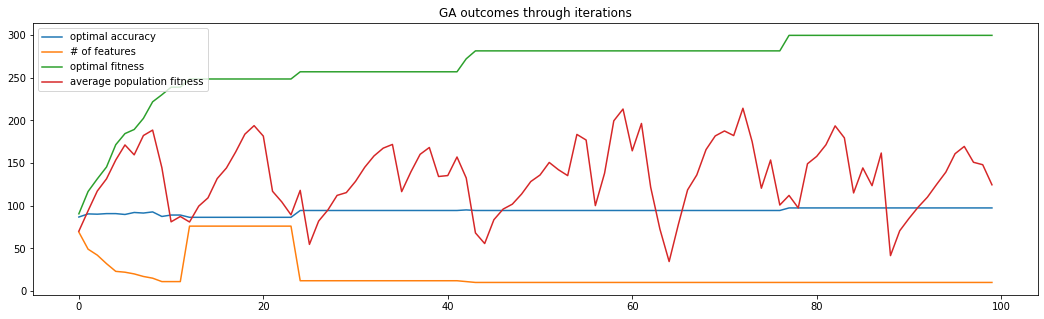

Final solution feature relevance: 
Feature: 41  Score: -0.20935
Feature: 57  Score: 1.00021
Feature: 70  Score: 0.11370
Feature: 75  Score: 0.13320
Feature: 114  Score: 0.57134
Feature: 149  Score: -0.10271
Feature: 165  Score: 0.12170
Feature: 188  Score: 0.20443
Feature: 199  Score: 0.03753
Feature: 200  Score: -2.28634


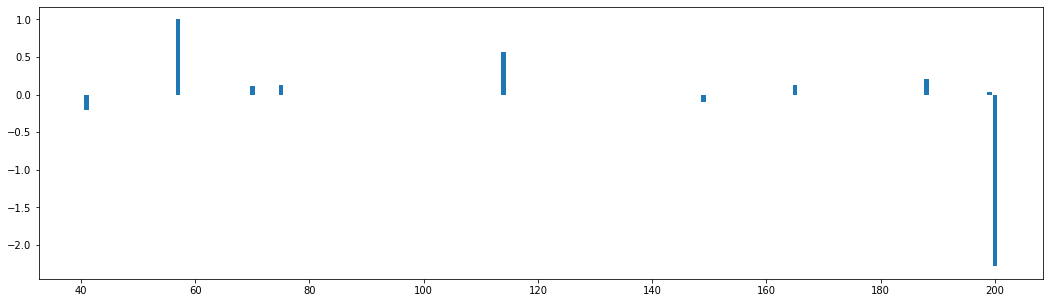

Trial  4
FINAL Optimal Feature Set
 [57, 198, 199, 200]
FINAL Optimal Accuracy = 90.0 %
Execution time is:  79.54240894317627
Number of selected features is:  4
Number of features selected through iterations: 


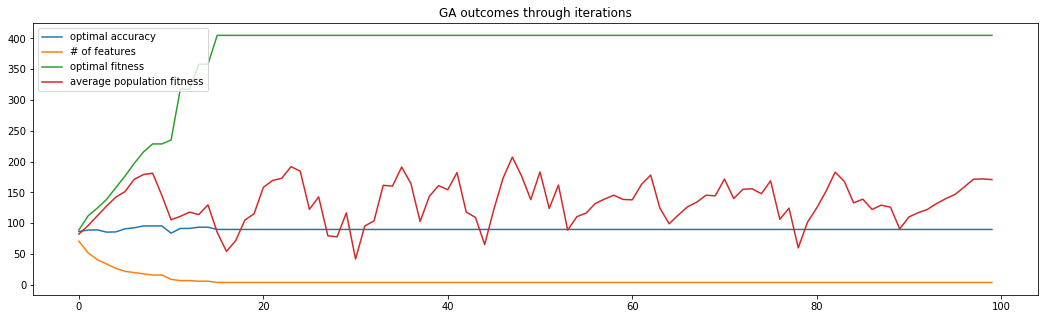

Final solution feature relevance: 
Feature: 57  Score: 0.86293
Feature: 198  Score: -0.02531
Feature: 199  Score: 0.17130
Feature: 200  Score: -3.29260


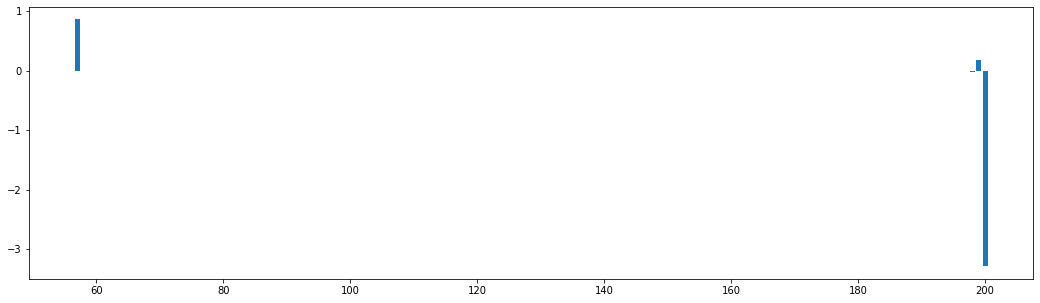

Trial  5
FINAL Optimal Feature Set
 [57, 70, 75, 104, 111, 114, 124, 132, 143, 165, 188, 199, 200]
FINAL Optimal Accuracy = 88.66666666666667 %
Execution time is:  87.15807604789734
Number of selected features is:  13
Number of features selected through iterations: 


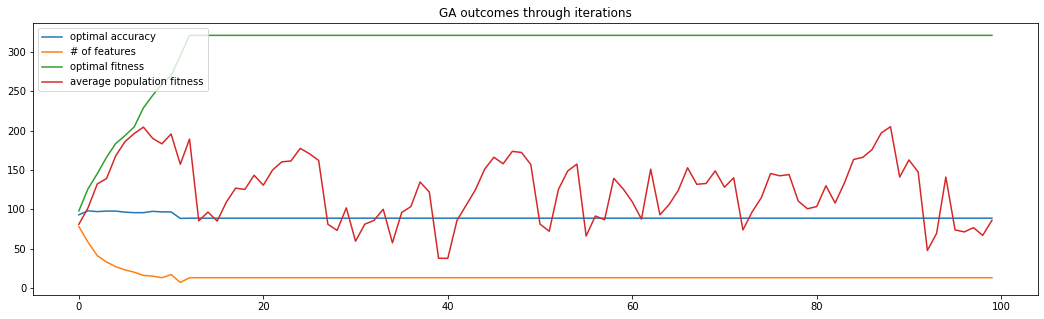

Final solution feature relevance: 
Feature: 57  Score: 0.93862
Feature: 70  Score: 0.15538
Feature: 75  Score: -0.06625
Feature: 104  Score: -0.18637
Feature: 111  Score: 0.15538
Feature: 114  Score: 0.56805
Feature: 124  Score: -0.14887
Feature: 132  Score: 0.19632
Feature: 143  Score: -0.18673
Feature: 165  Score: 0.20073
Feature: 188  Score: 0.15633
Feature: 199  Score: 0.00694
Feature: 200  Score: -2.04317


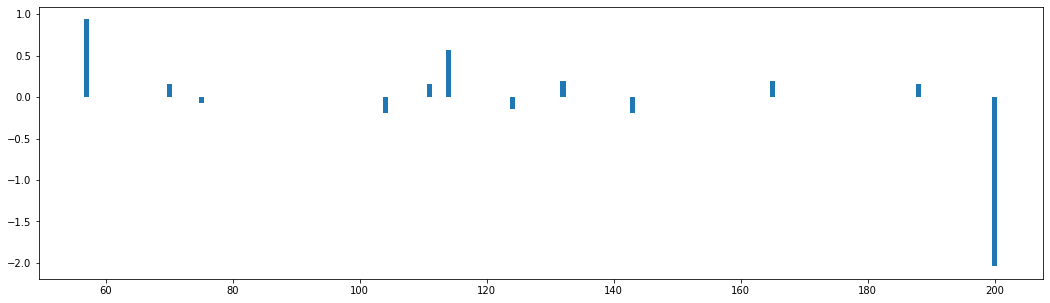

Trial  6
FINAL Optimal Feature Set
 [57, 75, 104, 114, 199, 200]
FINAL Optimal Accuracy = 94.0 %
Execution time is:  82.2698450088501
Number of selected features is:  6
Number of features selected through iterations: 


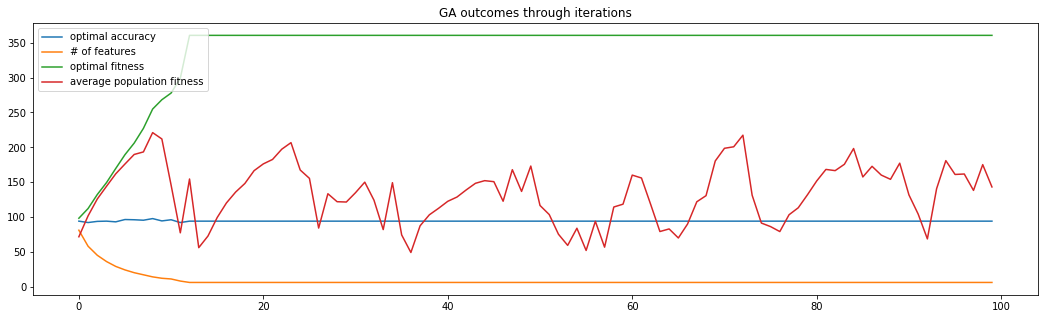

Final solution feature relevance: 
Feature: 57  Score: 1.04740
Feature: 75  Score: 0.19293
Feature: 104  Score: -0.14009
Feature: 114  Score: 0.53008
Feature: 199  Score: 0.03480
Feature: 200  Score: -2.33972


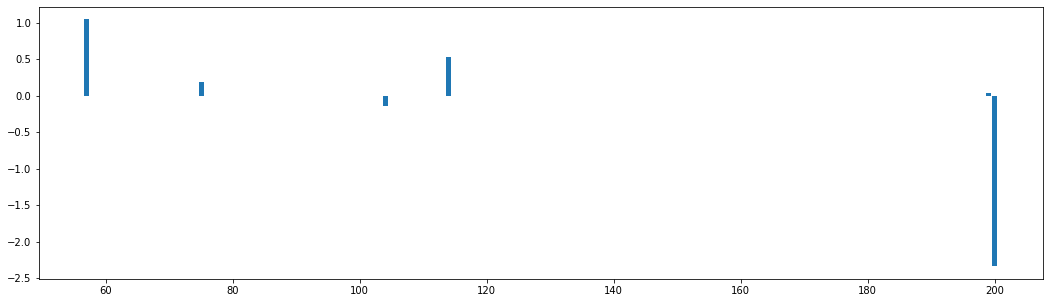

Trial  7
FINAL Optimal Feature Set
 [3, 5, 7, 13, 21, 31, 33, 35, 36, 44, 46, 47, 51, 52, 54, 57, 58, 62, 67, 72, 75, 85, 89, 91, 96, 97, 99, 105, 106, 108, 109, 111, 114, 126, 127, 128, 132, 137, 140, 141, 143, 149, 150, 153, 155, 156, 159, 160, 164, 165, 167, 172, 173, 178, 179, 182, 184, 185, 186, 188, 190, 191, 192, 195, 199, 200]
FINAL Optimal Accuracy = 85.0 %
Execution time is:  82.32177996635437
Number of selected features is:  66
Number of features selected through iterations: 


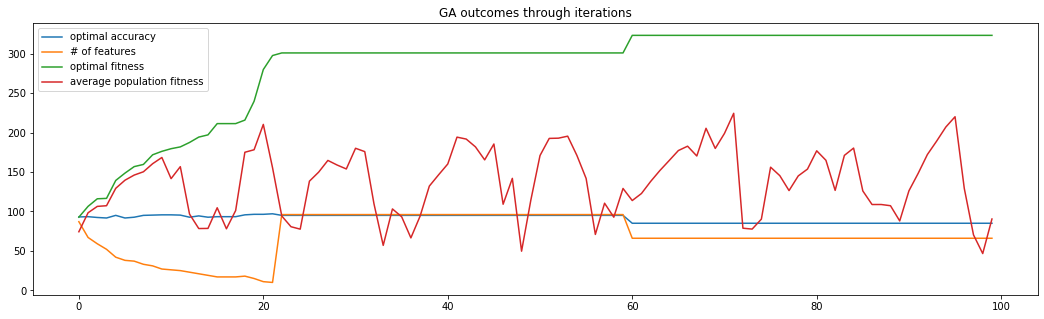

Final solution feature relevance: 
Feature: 3  Score: 0.02897
Feature: 5  Score: -0.05844
Feature: 7  Score: 0.01595
Feature: 13  Score: 0.06910
Feature: 21  Score: -0.00026
Feature: 31  Score: -0.10778
Feature: 33  Score: 0.06328
Feature: 35  Score: 0.13592
Feature: 36  Score: 0.09632
Feature: 44  Score: -0.13763
Feature: 46  Score: 0.05880
Feature: 47  Score: -0.07607
Feature: 51  Score: 0.11040
Feature: 52  Score: -0.07651
Feature: 54  Score: -0.00771
Feature: 57  Score: 0.91979
Feature: 58  Score: 0.00421
Feature: 62  Score: 0.03061
Feature: 67  Score: 0.04000
Feature: 72  Score: 0.15167
Feature: 75  Score: -0.05395
Feature: 85  Score: -0.03411
Feature: 89  Score: -0.02181
Feature: 91  Score: -0.01603
Feature: 96  Score: -0.07660
Feature: 97  Score: 0.13673
Feature: 99  Score: -0.01959
Feature: 105  Score: -0.10832
Feature: 106  Score: 0.03529
Feature: 108  Score: -0.06271
Feature: 109  Score: 0.03078
Feature: 111  Score: 0.22022
Feature: 114  Score: 0.56499
Feature: 126  Score: 0.

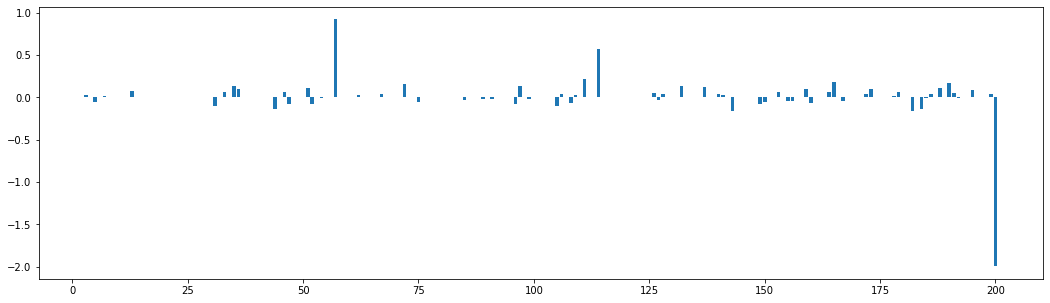

Trial  8
FINAL Optimal Feature Set
 [31, 57, 60, 70, 75, 95, 114, 165, 199, 200]
FINAL Optimal Accuracy = 95.66666666666667 %
Execution time is:  80.44175696372986
Number of selected features is:  10
Number of features selected through iterations: 


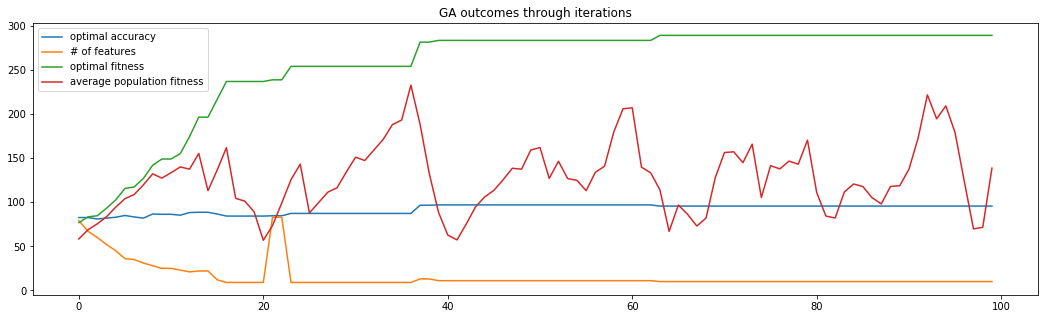

Final solution feature relevance: 
Feature: 31  Score: -0.12913
Feature: 57  Score: 1.03058
Feature: 60  Score: -0.15768
Feature: 70  Score: 0.19301
Feature: 75  Score: 0.12596
Feature: 95  Score: 0.24926
Feature: 114  Score: 0.53347
Feature: 165  Score: 0.09121
Feature: 199  Score: -0.04779
Feature: 200  Score: -2.23411


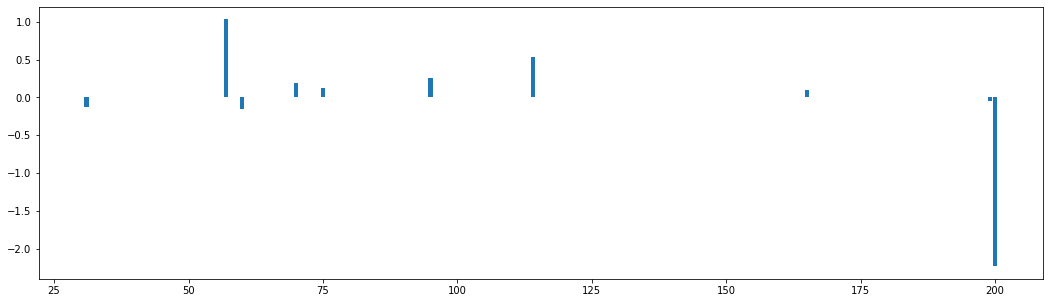

Trial  9
FINAL Optimal Feature Set
 [57, 75, 95, 104, 114, 143, 149, 165, 198, 200]
FINAL Optimal Accuracy = 96.66666666666667 %
Execution time is:  80.00968027114868
Number of selected features is:  10
Number of features selected through iterations: 


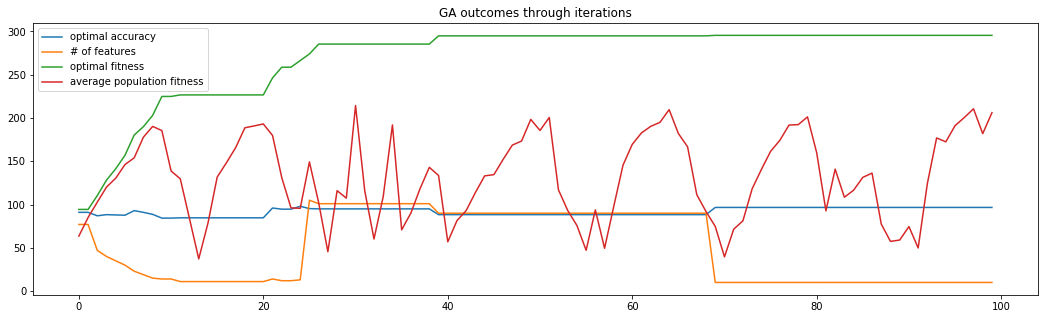

Final solution feature relevance: 
Feature: 57  Score: 0.99347
Feature: 75  Score: 0.13081
Feature: 95  Score: 0.14143
Feature: 104  Score: -0.23656
Feature: 114  Score: 0.57396
Feature: 143  Score: -0.15089
Feature: 149  Score: -0.12781
Feature: 165  Score: 0.13431
Feature: 198  Score: -0.05007
Feature: 200  Score: -2.17226


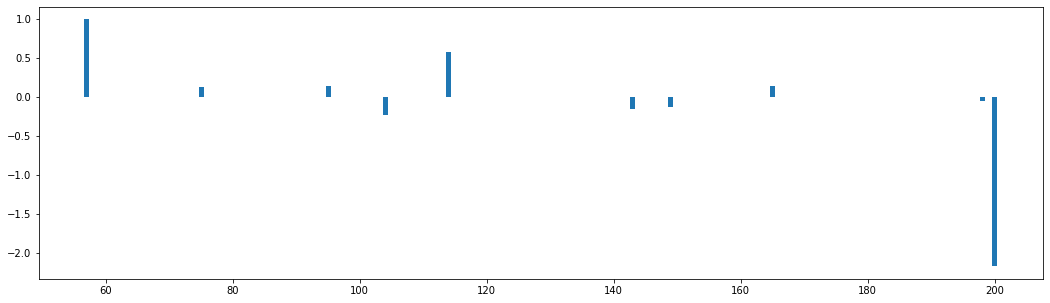

Trial  10
FINAL Optimal Feature Set
 [57, 71, 75, 95, 114, 143, 199, 200]
FINAL Optimal Accuracy = 93.66666666666667 %
Execution time is:  77.47277498245239
Number of selected features is:  8
Number of features selected through iterations: 


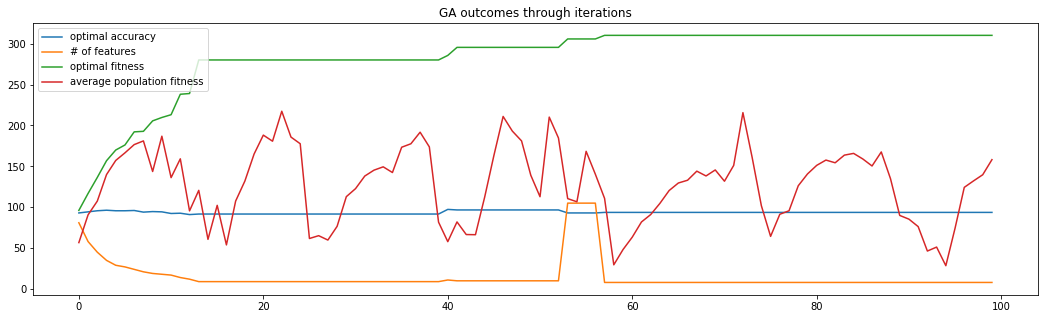

Final solution feature relevance: 
Feature: 57  Score: 1.03875
Feature: 71  Score: 0.14523
Feature: 75  Score: 0.18887
Feature: 95  Score: 0.28669
Feature: 114  Score: 0.61807
Feature: 143  Score: -0.12971
Feature: 199  Score: -0.09767
Feature: 200  Score: -2.25371


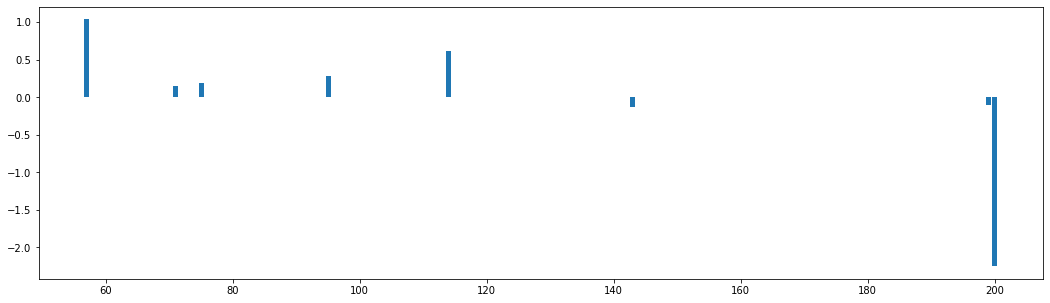

--------------------------------------------------
Average accuracy:  92.99999999999999
Average execution time:  812.875862121582
Average number of features selected:  14.1


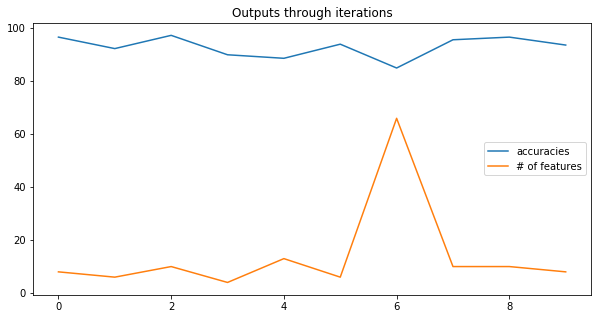

In [14]:
ga_multiple_trials(10, df4, feature_list4, target4, 10, 100)

Trial  1
FINAL Optimal Feature Set
 [35, 61, 72, 150, 162, 196, 200]
FINAL Optimal Accuracy = 93.33333333333333 %
Execution time is:  14.19689416885376
Number of selected features is:  7
Number of features selected through iterations: 


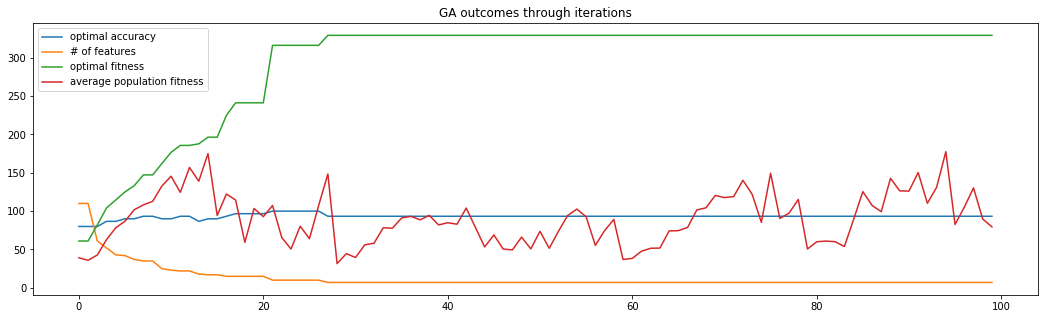

Final solution feature relevance: 
Feature: 35  Score: 0.07326
Feature: 61  Score: 0.40710
Feature: 72  Score: 0.32926
Feature: 150  Score: -0.33816
Feature: 162  Score: 0.48914
Feature: 196  Score: 0.15287
Feature: 200  Score: -2.84610


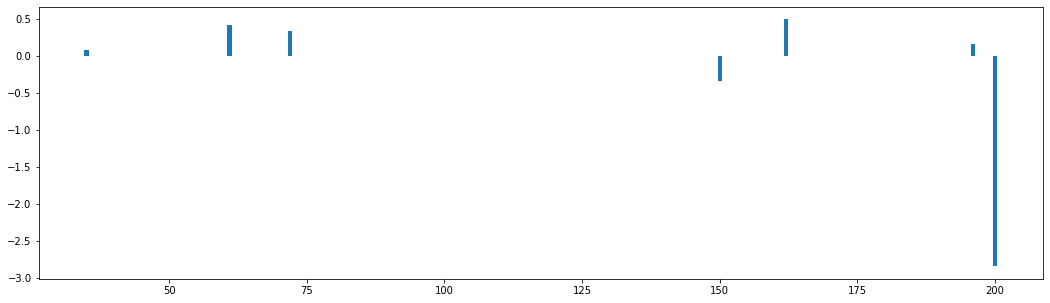

Trial  2
FINAL Optimal Feature Set
 [14, 124, 129, 141, 175, 180, 192, 198, 200]
FINAL Optimal Accuracy = 96.66666666666667 %
Execution time is:  14.109199047088623
Number of selected features is:  9
Number of features selected through iterations: 


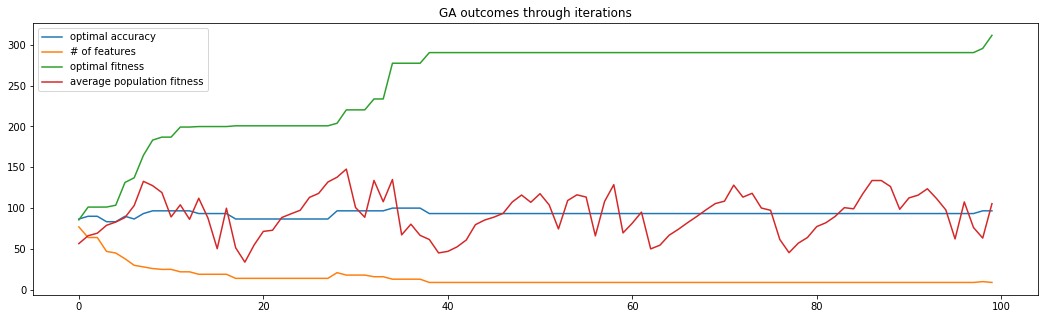

Final solution feature relevance: 
Feature: 14  Score: 0.80472
Feature: 124  Score: -0.28201
Feature: 129  Score: 0.62819
Feature: 141  Score: -0.51218
Feature: 175  Score: -0.26373
Feature: 180  Score: 0.15978
Feature: 192  Score: 0.14823
Feature: 198  Score: -0.44394
Feature: 200  Score: -2.73148


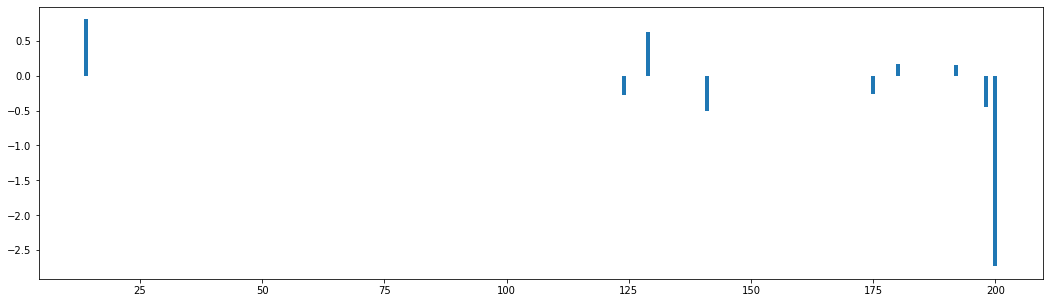

Trial  3
FINAL Optimal Feature Set
 [14, 58, 103, 129, 146, 176, 189, 199, 200]
FINAL Optimal Accuracy = 93.33333333333333 %
Execution time is:  14.234074115753174
Number of selected features is:  9
Number of features selected through iterations: 


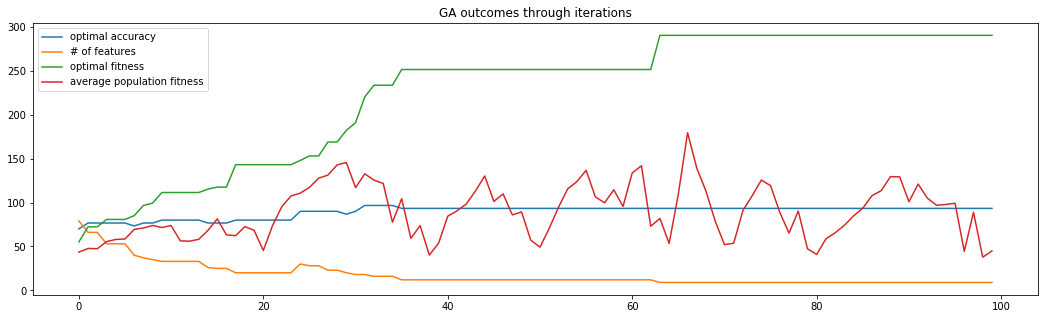

Final solution feature relevance: 
Feature: 14  Score: 0.44559
Feature: 58  Score: -0.47699
Feature: 103  Score: 0.37791
Feature: 129  Score: 0.53560
Feature: 146  Score: -0.19131
Feature: 176  Score: 0.32851
Feature: 189  Score: 0.13172
Feature: 199  Score: -0.39290
Feature: 200  Score: -2.81019


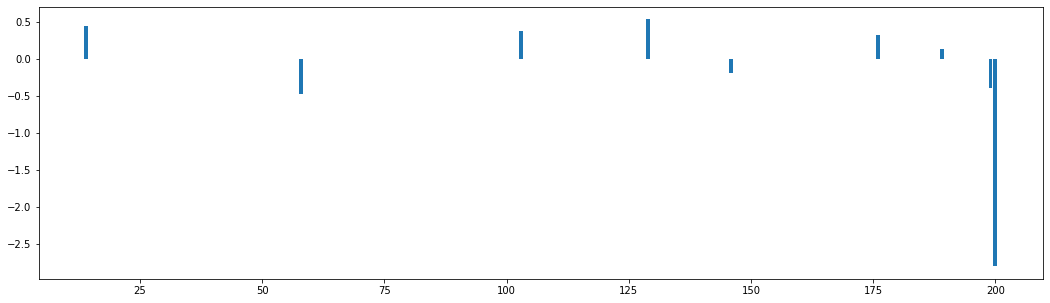

Trial  4
FINAL Optimal Feature Set
 [141, 161, 162, 163, 165, 173, 175, 178, 180, 184, 199, 200]
FINAL Optimal Accuracy = 86.66666666666667 %
Execution time is:  14.034808158874512
Number of selected features is:  12
Number of features selected through iterations: 


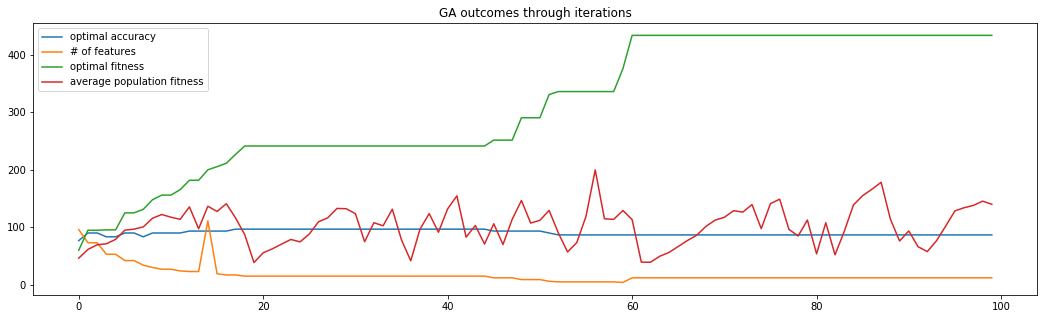

Final solution feature relevance: 
Feature: 141  Score: -0.62950
Feature: 161  Score: 0.02113
Feature: 162  Score: 0.36476
Feature: 163  Score: -0.09269
Feature: 165  Score: -0.35524
Feature: 173  Score: -0.45545
Feature: 175  Score: -0.49012
Feature: 178  Score: 0.31638
Feature: 180  Score: 0.33648
Feature: 184  Score: 0.46578
Feature: 199  Score: -0.30237
Feature: 200  Score: -2.64582


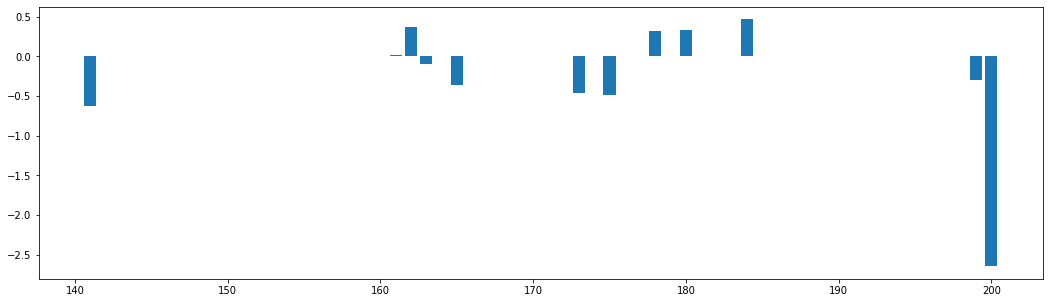

Trial  5
FINAL Optimal Feature Set
 [41, 86, 108, 135, 141, 146, 175, 176, 194, 199, 200]
FINAL Optimal Accuracy = 93.33333333333333 %
Execution time is:  14.250894784927368
Number of selected features is:  11
Number of features selected through iterations: 


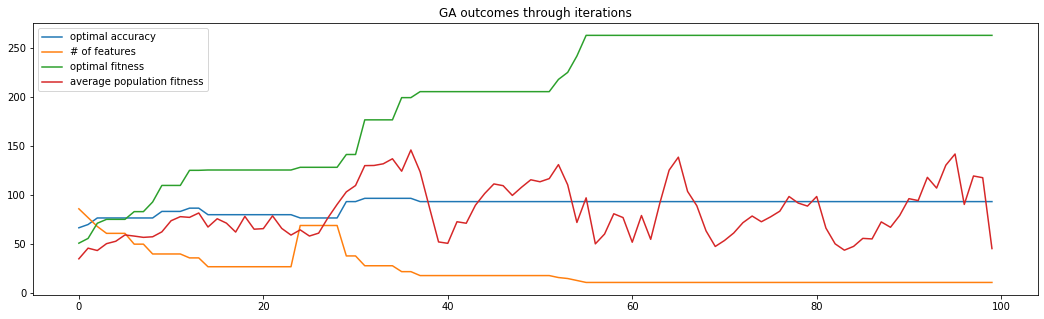

Final solution feature relevance: 
Feature: 41  Score: 0.43124
Feature: 86  Score: -0.73962
Feature: 108  Score: 0.68859
Feature: 135  Score: -0.29496
Feature: 141  Score: -0.65827
Feature: 146  Score: -0.34831
Feature: 175  Score: -0.40223
Feature: 176  Score: 0.25589
Feature: 194  Score: 0.22395
Feature: 199  Score: 0.28811
Feature: 200  Score: -2.42245


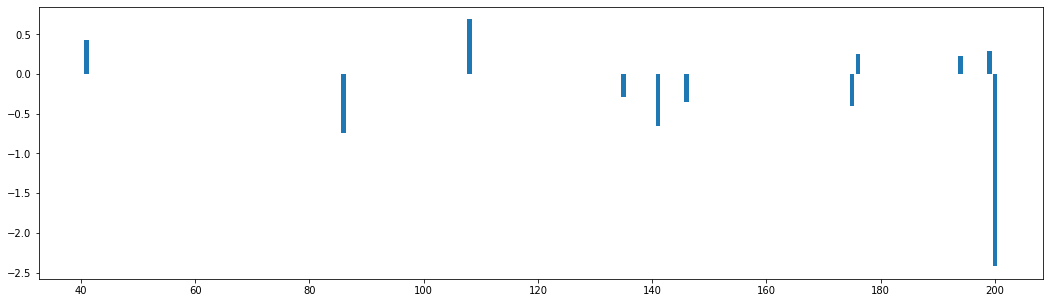

Trial  6
FINAL Optimal Feature Set
 [5, 8, 61, 141, 162, 165, 173, 194, 200]
FINAL Optimal Accuracy = 96.66666666666667 %
Execution time is:  14.062351703643799
Number of selected features is:  9
Number of features selected through iterations: 


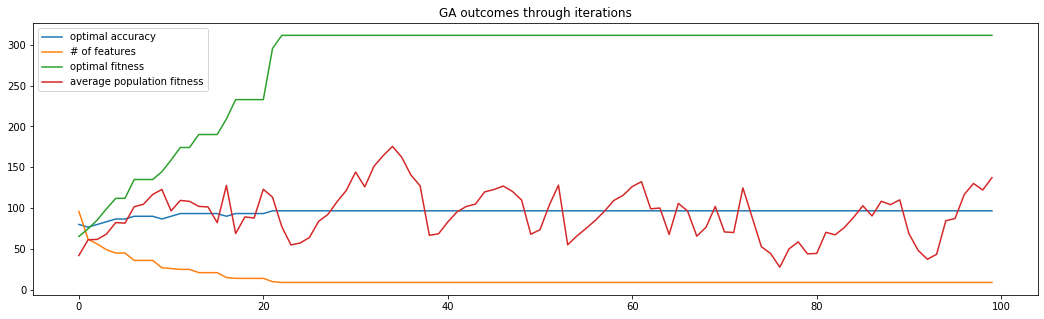

Final solution feature relevance: 
Feature: 5  Score: 0.50336
Feature: 8  Score: 0.31790
Feature: 61  Score: 0.22847
Feature: 141  Score: -0.52892
Feature: 162  Score: 0.55980
Feature: 165  Score: -0.33589
Feature: 173  Score: -0.30592
Feature: 194  Score: 0.03916
Feature: 200  Score: -2.56704


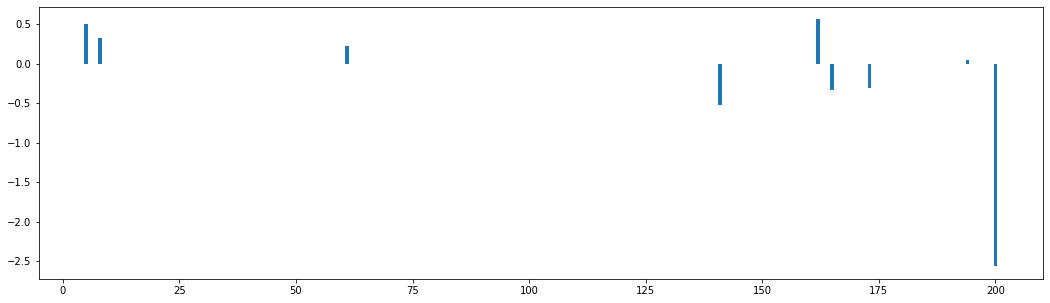

Trial  7
FINAL Optimal Feature Set
 [141, 173, 176, 184, 186, 194, 198, 200]
FINAL Optimal Accuracy = 90.0 %
Execution time is:  14.196907997131348
Number of selected features is:  8
Number of features selected through iterations: 


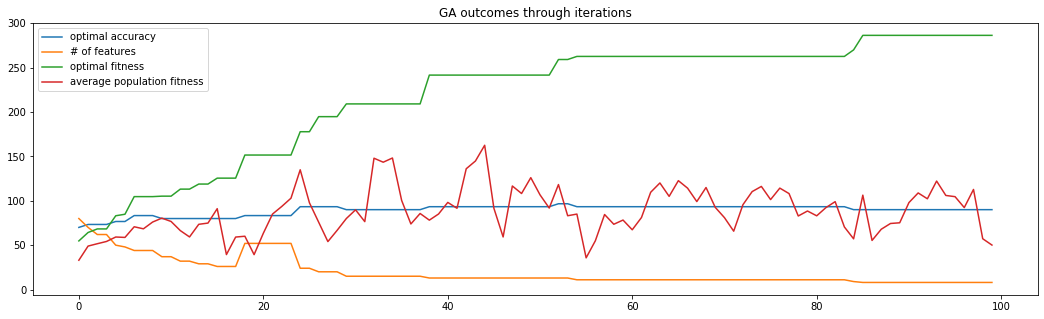

Final solution feature relevance: 
Feature: 141  Score: -0.54593
Feature: 173  Score: -0.39443
Feature: 176  Score: 0.22415
Feature: 184  Score: 0.01544
Feature: 186  Score: 0.13863
Feature: 194  Score: 0.26293
Feature: 198  Score: -0.52268
Feature: 200  Score: -2.78210


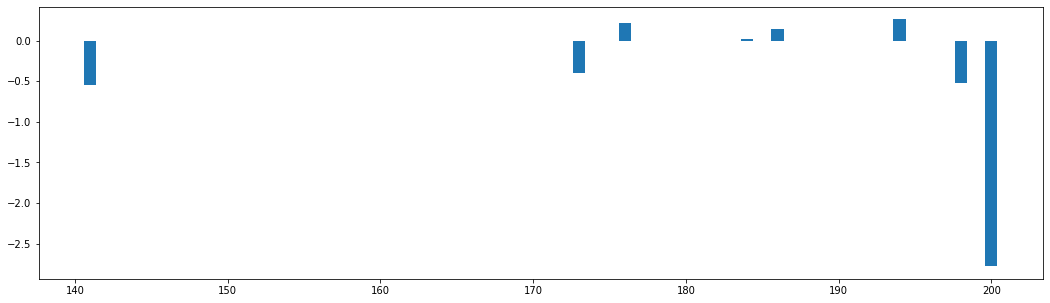

Trial  8
FINAL Optimal Feature Set
 [41, 61, 103, 148, 186, 199, 200]
FINAL Optimal Accuracy = 90.0 %
Execution time is:  14.046396970748901
Number of selected features is:  7
Number of features selected through iterations: 


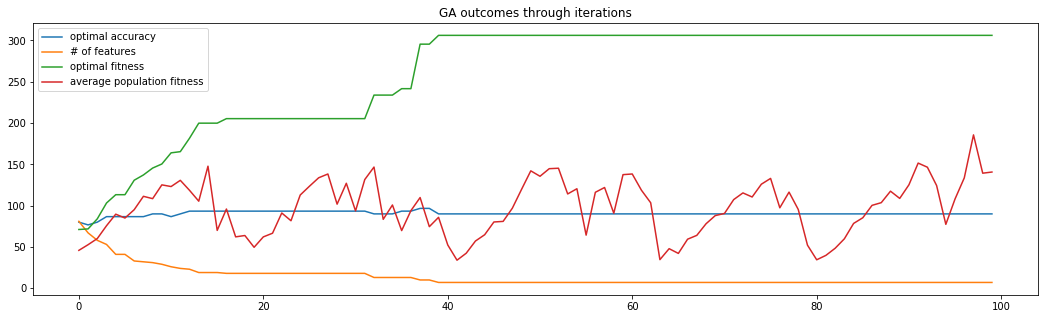

Final solution feature relevance: 
Feature: 41  Score: 0.35055
Feature: 61  Score: 0.27318
Feature: 103  Score: 0.48084
Feature: 148  Score: 0.01853
Feature: 186  Score: 0.38358
Feature: 199  Score: -0.00205
Feature: 200  Score: -2.89445


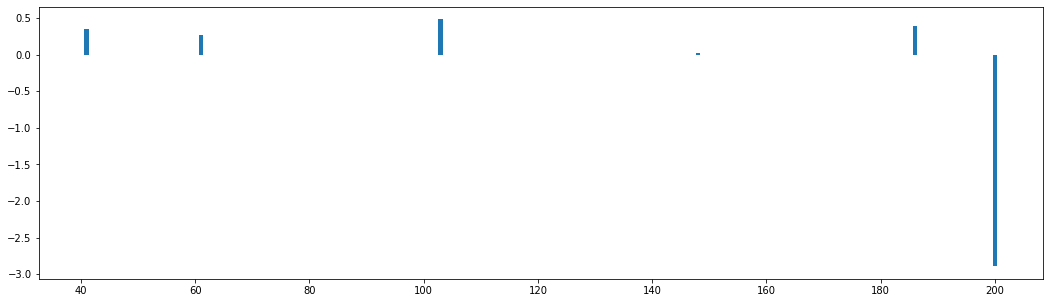

Trial  9
FINAL Optimal Feature Set
 [108, 134, 197, 200]
FINAL Optimal Accuracy = 86.66666666666667 %
Execution time is:  13.906461000442505
Number of selected features is:  4
Number of features selected through iterations: 


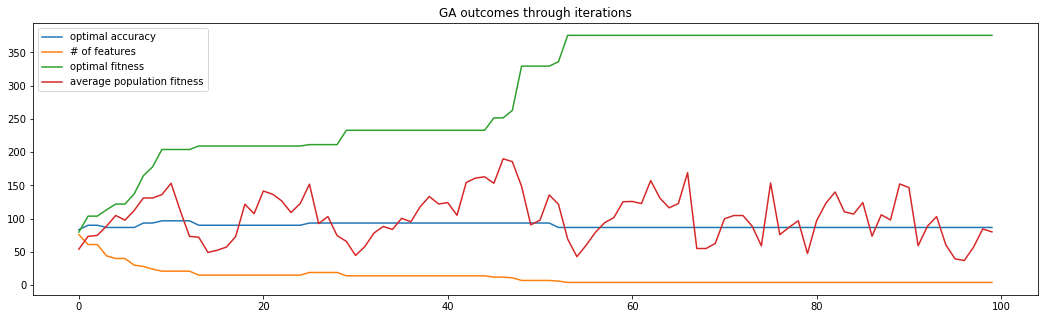

Final solution feature relevance: 
Feature: 108  Score: 0.66407
Feature: 134  Score: -0.37568
Feature: 197  Score: 0.06957
Feature: 200  Score: -2.93112


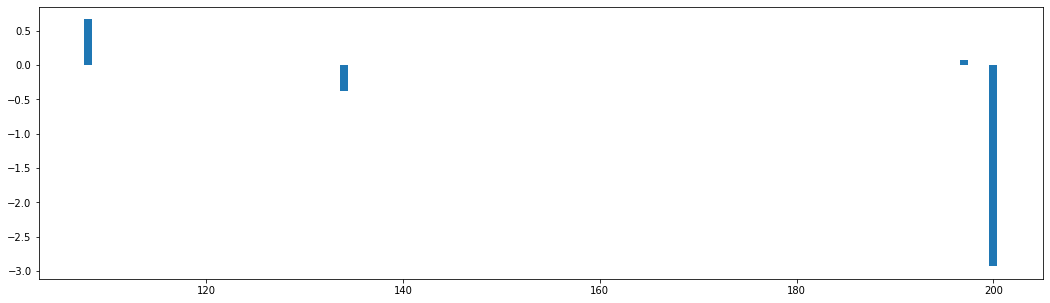

Trial  10
FINAL Optimal Feature Set
 [103, 108, 129, 162, 169, 176, 195, 199, 200]
FINAL Optimal Accuracy = 96.66666666666667 %
Execution time is:  14.045436143875122
Number of selected features is:  9
Number of features selected through iterations: 


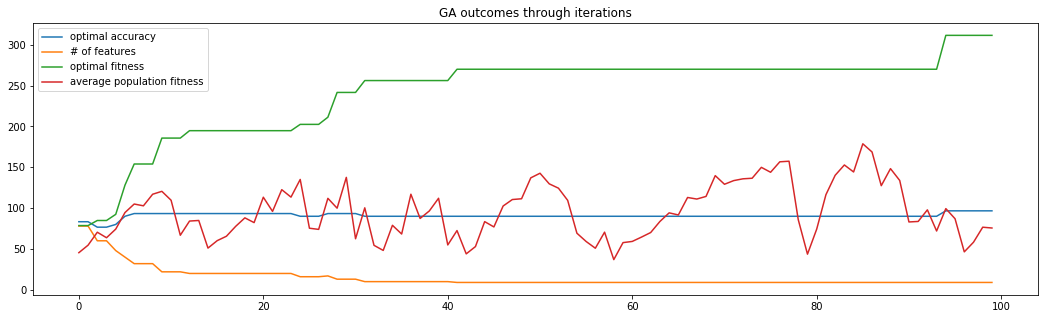

Final solution feature relevance: 
Feature: 103  Score: 0.40296
Feature: 108  Score: 1.02549
Feature: 129  Score: 0.67954
Feature: 162  Score: 0.51389
Feature: 169  Score: -0.42164
Feature: 176  Score: 0.65707
Feature: 195  Score: -0.00732
Feature: 199  Score: -0.26001
Feature: 200  Score: -2.22172


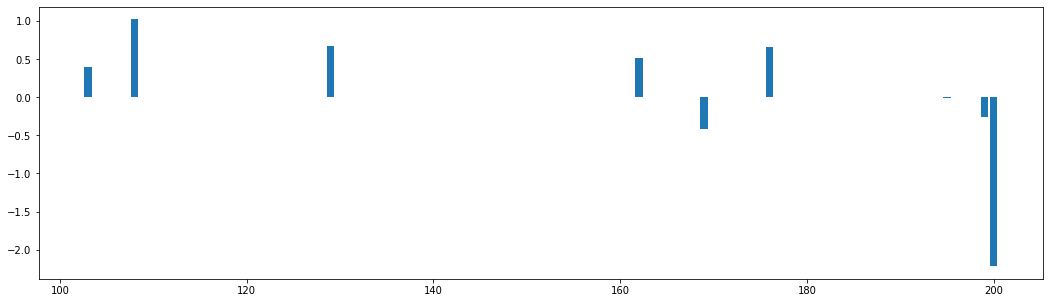

--------------------------------------------------
Average accuracy:  92.33333333333333
Average execution time:  141.0834240913391
Average number of features selected:  8.5


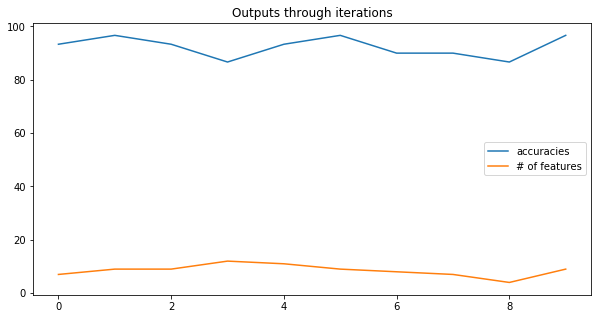

In [15]:
ga_multiple_trials(10, df5, feature_list5, target5, 10, 100)